In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import yaml

from scipy.stats import binned_statistic_2d
# import shap

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
space = ExpressionSpace.from_config(get_path('configs', 'v7.0', 'expression_space.yaml'))

In [3]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [4]:
MODELS = [
    # 'pysr',
    # 'nesymres-100M',
    'v7.0',
    'v7.11',
    'analysis_beams_v7.0/v7.0_512-beams'
    # 'v7.1',
    # 'v7.2',
    # 'v7.3',
    # 'v7.4',
    # 'v7.10'
]
MODELS_DESCRIPTION = {
    'nesymres-100M': 'NeSymReS 100M',
    'pysr': 'PySR',
}

for model in MODELS:
    if model not in MODELS_DESCRIPTION:
        MODELS_DESCRIPTION[model] = model

In [5]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool-15',
}
TEST_SET_TITLES_LONG = {
    'train': 'Train',
    'val': 'Validation',
    'feynman': 'Feynman',
    'soose_nc': 'SOOSE-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool-15',
}

In [6]:
configs = {}

for model in MODELS:
    with open(get_path(f'configs/{model}/evaluation.yaml'), 'r') as f:
        configs[model] = yaml.safe_load(f)

In [7]:
test_sets = {model: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{model}'))] for model in MODELS}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [8]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

In [9]:
remove_invalid = []

for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Loading {model} results'):
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            keys_to_remove.extend(['x', 'y'])

            for k in keys_to_remove:
                del test_set_results['data'][k]

Loading v7.11 results: 100%|██████████| 6/6 [02:00<00:00, 20.13s/it]
Loading analysis_beams_v7.0/v7.0_512-beams results: 100%|██████████| 4/4 [04:21<00:00, 65.43s/it]


In [10]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            results[model][test_set]['data']['wall_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))
            results[model][test_set]['data']['sys_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))

100%|██████████| 4/4 [00:00<00:00, 633.60it/s]


In [11]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']
        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])

        for j in range(beam_width):
            if f'free_beam_{j + 1}' in data:
                results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) for i in range(len(data[f'free_beam_{j + 1}']))])
            if f'residuals_beam_{j + 1}' in data:
                results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
        
        if '_beam_1' not in data:
            continue

        max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(beam_width))

        for j in range(beam_width):
            padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
            data[f'_beam_{j + 1}'] = np.array(padded_beam)


100%|██████████| 4/4 [00:00<00:00, 16.70it/s]


In [12]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        valid = True
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'residuals' in k and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


In [13]:
# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        for maybe_val in ['', '_val']:
            test_set_results['data'][f'is_finite{maybe_val}'] = np.array([np.isfinite(r2) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'FVU-eps_accuracy{maybe_val}'] = np.array([(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu{maybe_val}'] = np.array([1 - r2 for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])
            test_set_results['data'][f'log_fvu{maybe_val}'] = np.array([np.log10(max(1 - r2, np.finfo(np.float32).eps)) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'] = np.copy(test_set_results['data'][f'fvu{maybe_val}'])
            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'][test_set_results['data'][f'FVU-eps_accuracy{maybe_val}']] = np.nan

            test_set_results['data'][f'log_fvu_not_epsilon{maybe_val}'] = np.array([np.log10(fvu) for fvu in test_set_results['data'][f'fvu_not_epsilon{maybe_val}']])

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = [np.log10(ppl) for ppl in test_set_results['data']['perplexity']]
        else:
            test_set_results['data']['log_ppl'] = [np.nan] * len(test_set_results['data']['r2_best_beam'])

In [14]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'y_noisy', 'x_val', 'y_val', 'y_noisy_val', 'fit_time',  'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam', 'y_noisy'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c for i in range(1, 1024))}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
compare_columns

{'FVU-eps_accuracy',
 'FVU-eps_accuracy_val',
 'NSRTS_accuracy_close_best_beam',
 'NSRTS_accuracy_close_val_best_beam',
 'NSRTS_accuracy_r2_best_beam',
 'NSRTS_accuracy_r2_val_best_beam',
 'accuracy_best_beam',
 'beam_search_time',
 'best_beam',
 'bleu_best_beam',
 'edit_distance_best_beam',
 'f1_score_best_beam',
 'fvu',
 'fvu_not_epsilon',
 'fvu_not_epsilon_val',
 'fvu_val',
 'is_finite',
 'is_finite_val',
 'length_best_beam',
 'length_target',
 'log_fvu',
 'log_fvu_not_epsilon',
 'log_fvu_not_epsilon_val',
 'log_fvu_val',
 'log_ppl',
 'meteor_best_beam',
 'mse_best_beam',
 'mse_val_best_beam',
 'perplexity',
 'precision_best_beam',
 'r2_best_beam',
 'r2_val_best_beam',
 'recall_best_beam',
 'reciprocal_rank',
 'refiner_time_best_beam',
 'rouge1_fmeasure_best_beam',
 'rouge1_precision_best_beam',
 'rouge1_recall_best_beam',
 'rouge2_fmeasure_best_beam',
 'rouge2_precision_best_beam',
 'rouge2_recall_best_beam',
 'rougeL_fmeasure_best_beam',
 'rougeL_precision_best_beam',
 'rougeL_rec

In [15]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [16]:
compare_columns_defaults = {
    'FVU-eps_accuracy': 0,
    'perplexity': np.inf,
    'log_ppl': np.inf,
    'precision_best_beam': 0,
    'recall_best_beam': 0,
    'L_inf_best_beam': np.inf,
    'NSRTS_accuracy_close_best_beam': 0,
    'NSRTS_accuracy_r2_best_beam': 0,
    'NSRTS_accuracy_close_val_best_beam': 0,
    'NSRTS_accuracy_r2_val_best_beam': 0,
    'accuracy_best_beam': 0,
    'bleu_best_beam': 0,
    'edit_distance_best_beam': np.inf,
    'f1_score_best_beam': 0,
    'fvu': np.inf,
    'log_fvu': np.inf,
    'fvu_not_epsilon': np.inf,
    'log_fvu_not_epsilon': np.inf,
    'log_ppl': np.inf,
    'meteor_best_beam': 0,
    'mse_best_beam': np.inf,
    'mse_val_best_beam': np.inf,
    'perplexity': np.inf,
    'precision_best_beam': 0,
    'r2_best_beam': -np.inf,
    'r2_val_best_beam': -np.inf,
    'recall_best_beam': 0,
    'reciprocal_rank': 0,
    'rouge1_fmeasure_best_beam': 0,
    'rouge1_precision_best_beam': 0,
    'rouge1_recall_best_beam': 0,
    'rouge2_fmeasure_best_beam': 0,
    'rouge2_precision_best_beam': 0,
    'rouge2_recall_best_beam': 0,
    'rougeL_fmeasure_best_beam': 0,
    'rougeL_precision_best_beam': 0,
    'rougeL_recall_best_beam': 0,
    'structural_accuracy_best_beam': 0,
    'tree_edit_distance_best_beam': np.inf,
    'wall_time': np.inf,
    'sys_time': np.inf,
    'is_finite': 0,
}

In [17]:
from functools import partial

In [18]:
def naninfmean(x):
    return np.nanmean(np.array(x)[np.isfinite(x)])

In [19]:
N_BOOTSTRAPS = 1_000

In [20]:
summaries = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                summaries[model][test_set][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                summaries[model][test_set][column] = {k: (np.nan, ) * 3 for k in sub_metrics}

            if metrics is None:
                metrics = summaries[model][test_set][column].keys()

v7.0 train:  27%|██▋       | 13/48 [00:05<00:13,  2.60it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_beams_v7.0/v7.0_512-beams pool_15: 100%|██████████| 48/48 [00:05<00:00,  9.07it/s]


In [21]:
def ar_test(data1, data2, test_statistic, n):
    # Compute the observed test statistic.
    obs_stat = test_statistic(data1, data2)

    # Pool the data from both samples.
    pooled_data = np.concatenate((data1, data2))
    n1 = len(data1)
    
    # Count the number of times the permuted statistic is at least as extreme as the observed.
    extreme_count = 0
    for _ in range(n):
        # Permute the pooled data.
        permuted = np.random.permutation(pooled_data)
        # Split into two groups (using the original sample sizes).
        perm_group1 = permuted[:n1]
        perm_group2 = permuted[n1:]
        # Compute the test statistic for the permutation.
        perm_stat = test_statistic(perm_group1, perm_group2)
        # For a two-sided test: count if the absolute value is at least as extreme.
        if abs(perm_stat) >= abs(obs_stat):
            extreme_count += 1
    
    # Compute the p-value (with a small correction to avoid a zero p-value).
    p_value = (extreme_count) / (n)
    
    return obs_stat, p_value

In [ ]:
ar_p = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

reference_model = 'v7.0'

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                ar_p[model][test_set][column] = {m: ar_test(array_dfs[reference_model][test_set][column], data, lambda x, y: f(x) - f(y), n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                ar_p[model][test_set][column] = {k: (np.nan, ) * 2 for k in sub_metrics}

            if metrics is None:
                metrics = ar_p[model][test_set][column].keys()

In [23]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

summary_tables = {
    column: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    test_set: summaries[model][test_set][column][metric][k]
                    for test_set in summaries[model].keys()}
                    for model in summaries.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for column in compare_columns}

In [24]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

ar_tables = {
    column: {
        metric: {
            value:
                pd.DataFrame({
                model: {
                    test_set: ar_p[model][test_set][column][metric][k]
                    for test_set in ar_p[model].keys()}
                    for model in ar_p.keys()}).T.round(3)
                    for k, value in enumerate(['statistic', 'p'])}
                    for metric in metrics}
                    for column in compare_columns}

#### Validity

In [24]:
m = 'is_finite'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.0,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (0.999, 1.0)"
v7.11,"0.999 (0.998, 1.0)","0.999 (0.998, 1.0)","1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (1.0, 1.0)","0.999 (0.999, 1.0)"
analysis_beams_v7.0/v7.0_512-beams,"nan (nan, nan)","nan (nan, nan)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"


#### Recovery Rate

In [25]:
m = 'NSRTS_accuracy_close_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.0,"0.752 (0.739, 0.764)","0.751 (0.739, 0.762)","0.882 (0.873, 0.891)","0.821 (0.811, 0.832)","0.879 (0.87, 0.888)","0.647 (0.635, 0.661)"
v7.11,"0.372 (0.359, 0.386)","0.37 (0.357, 0.383)","0.892 (0.884, 0.901)","0.734 (0.722, 0.746)","0.906 (0.898, 0.915)","0.652 (0.638, 0.665)"
analysis_beams_v7.0/v7.0_512-beams,"nan (nan, nan)","nan (nan, nan)","0.96 (0.949, 0.971)","0.901 (0.881, 0.919)","0.983 (0.975, 0.991)","0.735 (0.709, 0.761)"


In [26]:
m = 'NSRTS_accuracy_r2_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.0,"0.893 (0.885, 0.902)","0.893 (0.885, 0.901)","0.937 (0.93, 0.943)","0.878 (0.869, 0.886)","0.985 (0.982, 0.989)","0.83 (0.82, 0.84)"
v7.11,"0.747 (0.735, 0.759)","0.727 (0.715, 0.74)","0.951 (0.946, 0.958)","0.824 (0.813, 0.834)","0.977 (0.973, 0.981)","0.832 (0.822, 0.842)"
analysis_beams_v7.0/v7.0_512-beams,"nan (nan, nan)","nan (nan, nan)","0.985 (0.977, 0.992)","0.934 (0.917, 0.949)","0.999 (0.997, 1.0)","0.906 (0.886, 0.924)"


In [27]:
m = 'FVU-eps_accuracy'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.0,"0.56 (0.547, 0.574)","0.565 (0.552, 0.579)","0.759 (0.748, 0.77)","0.708 (0.695, 0.721)","0.749 (0.737, 0.761)","0.364 (0.35, 0.376)"
v7.11,"0.159 (0.148, 0.169)","0.158 (0.148, 0.169)","0.753 (0.742, 0.766)","0.584 (0.57, 0.597)","0.775 (0.763, 0.787)","0.355 (0.342, 0.367)"
analysis_beams_v7.0/v7.0_512-beams,"nan (nan, nan)","nan (nan, nan)","0.869 (0.848, 0.889)","0.851 (0.829, 0.871)","0.947 (0.932, 0.961)","0.469 (0.44, 0.499)"


In [29]:
m = 'FVU-eps_accuracy'
sm = 'mean'
ar_tables[m][sm]['p']

,feynman,soose_nc,nguyen,pool_15,train,val
pysr,0.000,0.0,0.007,0.549,NaN,NaN
nesymres-100M,0.000,0.0,0.000,0.000,NaN,NaN
v7.0,1.000,1.0,1.000,1.000,1.0,1.0
v7.11,0.504,0.0,0.003,0.354,0.0,0.0


In [28]:
m = 'FVU-eps_accuracy_val'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.0,"0.554 (0.54, 0.567)","0.563 (0.549, 0.576)","0.756 (0.745, 0.769)","0.708 (0.695, 0.721)","0.749 (0.737, 0.761)","0.358 (0.346, 0.372)"
v7.11,"0.148 (0.139, 0.158)","0.142 (0.133, 0.151)","0.75 (0.739, 0.762)","0.583 (0.569, 0.597)","0.775 (0.764, 0.786)","0.35 (0.337, 0.363)"
analysis_beams_v7.0/v7.0_512-beams,"nan (nan, nan)","nan (nan, nan)","0.867 (0.846, 0.886)","0.851 (0.827, 0.874)","0.947 (0.932, 0.961)","0.462 (0.433, 0.496)"


#### Numeric Error

In [29]:
m = 'fvu_not_epsilon'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.0,"0.159 (0.145, 0.174)","0.156 (0.143, 0.171)","0.18 (0.159, 0.201)","0.372 (0.333, 0.426)","0.013 (0.01, 0.017)","0.194 (0.163, 0.238)"
v7.11,"18.095 (0.244, 54.071)","90627110318758.9 (0.264, 278597189676307.0)","0.142 (0.121, 0.166)","0.463 (0.373, 0.637)","0.045 (0.028, 0.077)","0.632 (0.23, 1.198)"
analysis_beams_v7.0/v7.0_512-beams,"nan (nan, nan)","nan (nan, nan)","0.044 (0.017, 0.078)","0.353 (0.279, 0.429)","0.005 (0.001, 0.013)","0.081 (0.061, 0.104)"


In [30]:
m = 'fvu_not_epsilon_val'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.0,"1.3127556978946003e+19 (44771.992, 3.944139254...","4.0550093023012355e+238 (2023361910.772, 1.247...","1730.933 (108.76, 4135.778)","119.03 (3.173, 364.323)","0.014 (0.01, 0.017)","3.8452365383109917e+77 (467829.672, 1.18257563..."
v7.11,1.3145298490070517e+295 (6.179523931052614e+18...,2.2561456875719438e+192 (1.3485078790207822e+1...,"39829.949 (38.888, 124513.64)","16.202 (2.522, 37.921)","0.047 (0.029, 0.076)","1.7793216506528628e+23 (262.098, 5.41297074874..."
analysis_beams_v7.0/v7.0_512-beams,"nan (nan, nan)","nan (nan, nan)","9.637 (0.083, 34.819)","0.492 (0.369, 0.69)","0.005 (0.001, 0.012)","540689483.447 (0.486, 1557590953.531)"


In [31]:
m = 'wall_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.0,"1.003 (1.0, 1.005)","1.006 (1.003, 1.008)","0.996 (0.993, 0.998)","0.986 (0.984, 0.987)","0.998 (0.996, 0.999)","1.029 (1.024, 1.033)"
v7.11,"1.206 (1.195, 1.213)","1.205 (1.196, 1.213)","1.084 (1.079, 1.087)","1.104 (1.098, 1.109)","1.066 (1.057, 1.072)","1.18 (1.17, 1.191)"
analysis_beams_v7.0/v7.0_512-beams,"nan (nan, nan)","nan (nan, nan)","38.635 (37.774, 39.519)","36.389 (35.695, 37.133)","40.842 (39.741, 42.72)","43.307 (41.49, nan)"


In [32]:
m = 'sys_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.0,"1.003 (1.0, 1.005)","1.006 (1.004, 1.008)","0.996 (0.994, 0.998)","0.986 (0.984, 0.988)","0.998 (0.996, 0.999)","1.029 (1.025, 1.033)"
v7.11,"1.206 (1.195, 1.214)","1.205 (1.196, 1.213)","1.084 (1.08, 1.087)","1.104 (1.098, 1.109)","1.065 (1.057, 1.073)","1.18 (1.17, 1.192)"
analysis_beams_v7.0/v7.0_512-beams,"nan (nan, nan)","nan (nan, nan)","38.633 (37.77, 39.391)","36.388 (35.695, 37.058)","40.842 (39.809, 42.689)","43.274 (41.456, nan)"


#### Text Metrics

In [33]:
m = 'perplexity'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.0,"4.152 (3.98, 4.35)","4.115 (3.913, 4.333)","2.284 (2.198, 2.386)","2.005 (1.957, 2.08)","5.066 (4.75, 5.377)","16.104 (14.731, 17.442)"
v7.11,"11.541 (11.1, 11.977)","11.417 (11.027, 11.804)","1.965 (1.92, 2.03)","2.727 (2.65, 2.805)","3.978 (3.705, 4.204)","8.889 (8.559, 9.218)"
analysis_beams_v7.0/v7.0_512-beams,"nan (nan, nan)","nan (nan, nan)","2.331 (2.134, 2.596)","1.918 (1.813, 2.046)","4.91 (4.441, 5.626)","14.542 (12.244, 17.467)"


In [34]:
m = 'tree_edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.0,"14.346 (14.086, 14.629)","14.052 (13.762, 14.335)","11.089 (10.831, 11.348)","7.634 (7.413, 7.859)","12.457 (12.131, 12.78)","21.89 (21.551, 22.258)"
v7.11,"34.982 (34.694, 35.273)","35.066 (34.773, 35.35)","14.356 (13.992, 14.738)","15.649 (15.228, 16.081)","15.608 (15.237, 15.961)","27.72 (27.312, 28.132)"
analysis_beams_v7.0/v7.0_512-beams,"nan (nan, nan)","nan (nan, nan)","11.74 (11.128, 12.316)","6.733 (6.244, 7.309)","11.451 (10.732, 12.127)","22.006 (21.173, 22.74)"


In [35]:
m = 'f1_score_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.0,"0.891 (0.888, 0.894)","0.889 (0.886, 0.891)","0.918 (0.916, 0.921)","0.906 (0.902, 0.91)","0.834 (0.83, 0.839)","0.858 (0.855, 0.861)"
v7.11,"0.847 (0.845, 0.85)","0.85 (0.847, 0.852)","0.916 (0.913, 0.919)","0.869 (0.864, 0.873)","0.805 (0.8, 0.809)","0.856 (0.853, 0.858)"
analysis_beams_v7.0/v7.0_512-beams,"nan (nan, nan)","nan (nan, nan)","0.914 (0.908, 0.919)","0.931 (0.924, 0.938)","0.859 (0.85, 0.869)","0.864 (0.857, 0.87)"


In [36]:
m = 'meteor_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.0,"0.644 (0.637, 0.65)","0.65 (0.643, 0.657)","0.737 (0.731, 0.744)","0.786 (0.779, 0.793)","0.63 (0.621, 0.639)","0.529 (0.522, 0.535)"
v7.11,"0.46 (0.456, 0.464)","0.456 (0.452, 0.46)","0.726 (0.718, 0.733)","0.692 (0.684, 0.7)","0.632 (0.623, 0.641)","0.535 (0.53, 0.542)"
analysis_beams_v7.0/v7.0_512-beams,"nan (nan, nan)","nan (nan, nan)","0.734 (0.72, 0.748)","0.834 (0.819, 0.849)","0.699 (0.681, 0.719)","0.553 (0.537, 0.567)"


In [37]:
m = 'edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
v7.0,"5.667 (5.566, 5.769)","5.526 (5.425, 5.631)","4.18 (4.085, 4.271)","2.83 (2.748, 2.915)","4.133 (4.023, 4.241)","8.78 (8.637, 8.923)"
v7.11,"13.88 (13.768, 13.982)","13.914 (13.807, 14.028)","5.648 (5.498, 5.795)","6.327 (6.143, 6.505)","4.951 (4.837, 5.058)","10.793 (10.641, 10.948)"
analysis_beams_v7.0/v7.0_512-beams,"nan (nan, nan)","nan (nan, nan)","4.591 (4.375, 4.8)","2.606 (2.427, 2.788)","3.808 (3.559, 4.041)","8.663 (8.353, 8.976)"


In [38]:
def table_to_typst(tables, column, metric, caption, test_set_titles, tag, negate=False, objective='max', font_size=9, ci_font_size=6, fmt_fn=None, factor=1, sem=True):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if sem:
        main_df = tables[column][metric]['median'] * (-1 if negate else 1)
        lower_df = tables[column][metric]['lower'] * (-1 if negate else 1)
        upper_df = tables[column][metric]['upper'] * (-1 if negate else 1)
    else:
        main_df = tables[column][metric]['median'] * (-1 if negate else 1)
        lower_df = tables[column]['2.5p']['median'] * (-1 if negate else 1)
        upper_df = tables[column]['97.5p']['median'] * (-1 if negate else 1)

    # Determine the best model for each test set
    best_model = main_df.idxmax(axis=0) if objective == 'max' else main_df.idxmin(axis=0)

    if objective == 'max':
        equal_mask = pd.DataFrame({test_set: upper_df[test_set] >= lower_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in upper_df})
    else:
        equal_mask = pd.DataFrame({test_set: lower_df[test_set] <= upper_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in lower_df})

    # print(equal_mask)

    output = f'''
#figure(
  [
    #show <table_CI>: set text({ci_font_size}pt)
    #text(
    size:{font_size}pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {{
      (right: (
      thickness: 0.5pt,
      ))
    }},
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
'''

    output += f"  [*Model*], "
    for test_set in test_set_titles.values():
        output += f"[*{test_set}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        flash = '#emoji.lightning ' if main_row[0].startswith('v') else ''
        output += f"  [{flash + MODELS_DESCRIPTION[main_row[0]]}], "
        output += ", ".join([
            '[' + ("*" if equal_best_row[1].get(test_set, False) else '') + f"{fmt_fn(main_row[1].get(test_set, np.nan) * factor)}\ #[(${fmt_fn(lower_row[1].get(test_set, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(test_set, np.nan) * factor)}$)] <table_CI>" + ("*" if equal_best_row[1].get(test_set, False) else '') + ']'
            for test_set in test_set_titles.keys()
        ]) + ",\n"

    output = output.replace('nan', '---').replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
  ))],
  caption: [{caption}],
  gap: 1.2em,
) <{tag}>
'''

    return output

In [39]:
def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [42]:
print(table_to_typst(summary_tables, 'FVU-eps_accuracy', 'mean', caption='*Recovery Rate in $bold("%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped 95% CI.', test_set_titles=TEST_SET_TITLES, tag='tab:results_fvu_eps_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(6pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool-15*], 
  table.hline(stroke: 0.5pt),
  [PySR], [---\ #[(---, ---)] <table_CI>], [---\ #[(---, ---)] <table_CI>], [69.1\ #[($66.3$, $72.1$)] <table_CI>], [60.5\ #[($57.0$, $63.5$)] <table_CI>], [*79.3\ #[($76.9$, $81.7$)] <table_CI>*], [*35.3\ #[($32.2$, $38.1$)] <table_CI>*],
  [NeSymReS 100M], [---\ #[(---, ---)] <table_CI>], [---\ #[(---, ---)] <table_CI>], [51.4\ #[($48.3$, $54.4$)] <table_CI>], [26.5\ #[($23.7$, $29.2$)] <table_CI>], [54.2\ #[($51.1$, $57.4$)] <table_CI>], [11.3\ #[($9.30$, $13.3$)] <table_CI>],
  [#emoji.lightning v7.0], [*56.0\ #[($54.6$, $57.3$)] <table_CI>*], [*56.5\ #[($55.1$, $57.9

In [43]:
# print(table_to_typst(summary_tables, 'NSRTS_accuracy_r2_best_beam', 'mean', caption='*Recovery Rate in $bold("%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped 95% CI.', test_set_titles=TEST_SET_TITLES, tag='tab:results_r2_rate', factor=100, fmt_fn=fmt_fn_100))

In [44]:
print(table_to_typst(summary_tables, 'edit_distance_best_beam', 'mean', caption='*Levenshtein Edit Distance $bold(attach(arrow.b, tr:[0, oo]))$.* Bootstrapped 95% CI.', test_set_titles=TEST_SET_TITLES, tag='tab:results_edit_distance', objective='min'))


#figure(
  [
    #show <table_CI>: set text(6pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool-15*], 
  table.hline(stroke: 0.5pt),
  [PySR], [---\ #[(---, ---)] <table_CI>], [---\ #[(---, ---)] <table_CI>], [10.69\ #[($10.21$, $11.13$)] <table_CI>], [11.38\ #[($11.00$, $11.80$)] <table_CI>], [8.78\ #[($8.44$, $9.12$)] <table_CI>], [14.80\ #[($14.46$, $15.14$)] <table_CI>],
  [NeSymReS 100M], [---\ #[(---, ---)] <table_CI>], [---\ #[(---, ---)] <table_CI>], [7.20\ #[($6.96$, $7.46$)] <table_CI>], [8.00\ #[($7.81$, $8.21$)] <table_CI>], [6.65\ #[($6.35$, $6.96$)] <table_CI>], [12.26\ #[($12.01$, $12.49$)] <table_CI>],
  [#emoji.lightning v7.0], [*5.66\ #[($5.55$, $5.77$)] <table_CI>*], [*5.52\ #[($5.42

# Length

In [41]:
data_lengths = {model: {test_set: None for test_set in TEST_SETS} for model in array_dfs.keys()}

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        if len(model_dfs) == 0:
            continue
        data_lengths[model][test_set] = {length: df[df['length_target'] == length] for length in range(32)}

/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


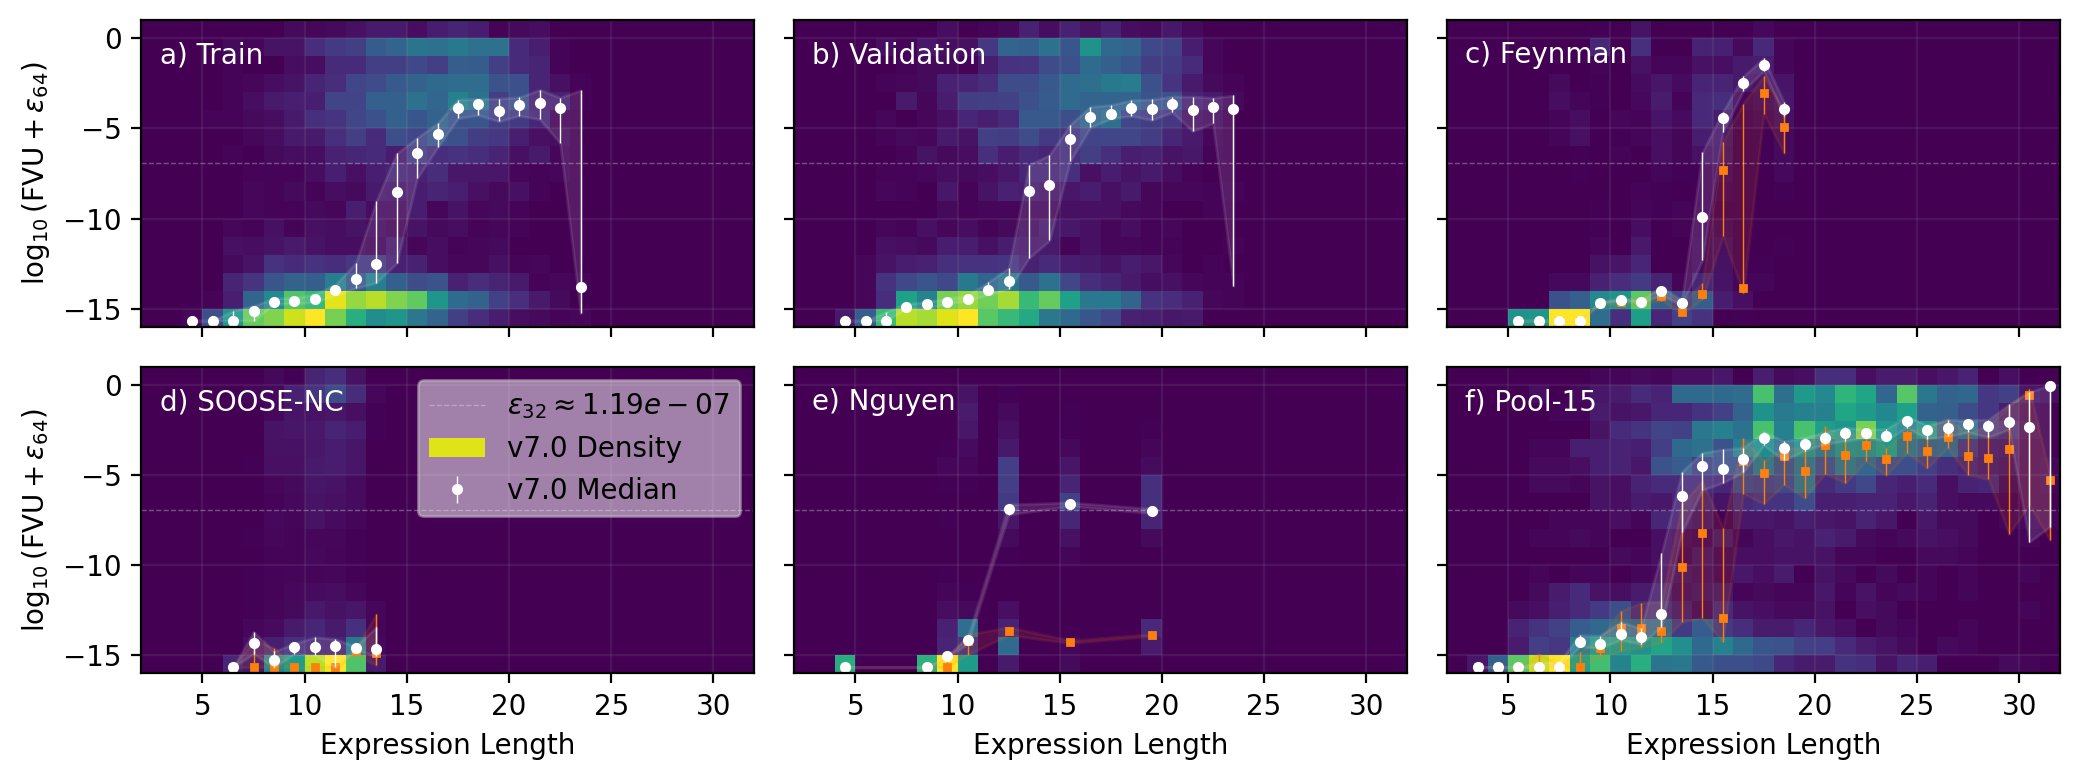

In [45]:
show_model = 'v7.0'
show_model_2 = 'analysis_beams_v7.0/v7.0_512-beams'
metric = 'fvu'

COLS = 3
ROWS = 2

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.5, ROWS * 2), dpi=200, sharex=True, sharey=True)


for i, (ax, test_set) in enumerate(zip(axes.flatten(), TEST_SETS)):
    ax.hist2d(
        array_dfs[show_model][test_set]['length_target'],
        np.log10(array_dfs[show_model][test_set]['fvu'] + np.finfo(np.float64).eps),
        bins=(np.arange(2, 33), np.linspace(-16, 1, 18)),
        cmap='viridis',
        rasterized=True)

    # Draw the median FVU for each length
    bootstraps = [bootstrapped_metric_ci(data_lengths[show_model][test_set][length][metric].values + np.finfo(np.float64).eps, np.nanmedian, n=N_BOOTSTRAPS) for length in range(2, 32)]
    median = [b[0] for b in bootstraps]
    lower = [b[1] for b in bootstraps]
    upper = [b[2] for b in bootstraps]

    valid_mask = ~np.isnan(median)

    index = np.arange(2, 32)[valid_mask]
    median = np.array(median)[valid_mask]
    lower = np.array(lower)[valid_mask]
    upper = np.array(upper)[valid_mask]

    ax.errorbar(index + 0.5, np.log10(median), yerr=[np.log10(median) - np.log10(lower), np.log10(upper) - np.log10(median)], fmt='.', color='w', lw=0.5, label='v7.0 Median', zorder=2)
    ax.fill_between(index + 0.5, np.log10(lower), np.log10(upper), color='w', alpha=0.1, zorder=2)

    if show_model_2 in data_lengths and data_lengths[show_model_2][test_set] is not None:
        bootstraps = [bootstrapped_metric_ci(data_lengths[show_model_2][test_set][length][metric].values + np.finfo(np.float64).eps, np.nanmedian, n=N_BOOTSTRAPS) for length in range(2, 32)]
        median = [b[0] for b in bootstraps]
        lower = [b[1] for b in bootstraps]
        upper = [b[2] for b in bootstraps]

        valid_mask = ~np.isnan(median)

        index = np.arange(2, 32)[valid_mask]
        median = np.array(median)[valid_mask]
        lower = np.array(lower)[valid_mask]
        upper = np.array(upper)[valid_mask]

        ax.errorbar(index + 0.5, np.log10(median), yerr=[np.log10(median) - np.log10(lower), np.log10(upper) - np.log10(median)], fmt='s', color='tab:orange', lw=0.5, label=f'{show_model_2} Median', zorder=1, markersize=2)
        ax.fill_between(index + 0.5, np.log10(lower), np.log10(upper), color='tab:orange', alpha=0.1, zorder=1)

    ax.grid(zorder=0, alpha=0.1)
    ax.annotate(f'{chr(ord("a") + i)}) {TEST_SET_TITLES_LONG[test_set]}', xy=(0.03, 0.93), xycoords='axes fraction', ha='left', va='top', color='w')
    if i % COLS == 0:
        ax.set_ylabel('$\\log_{10}(\\text{FVU} + \\epsilon_{64})$')
    if i >= (ROWS - 1) * COLS:
        ax.set_xlabel('Expression Length')

    ax.axhline(np.log10(np.finfo(np.float32).eps), color='w', lw=0.5, ls='--', alpha=0.3, zorder=1, label='$\\epsilon_{32} \\approx' + f'{np.finfo(np.float32).eps:.2e}$')

fig.tight_layout()

# Add a handle for the histogram
l = plt.Rectangle((0, 0), 0.5, 1, fc=plt.get_cmap('viridis')(0.95))

handles, labels = axes[0, 1].get_legend_handles_labels()
handles.insert(1, l)
labels.insert(1, 'v7.0 Density')

axes[1, 0].legend(framealpha=0.5, handles=handles, labels=labels, loc='upper right')

if 'v7.2' in data_lengths:
    plt.savefig(get_path('results', 'main', create=True, filename='fvu_length_heatmaps_comparison.svg'), bbox_inches='tight')

In [56]:
model = 'v7.0'
test_set = 'pool_15'
for i in range(10):
    print(f"L = {len(results[model][test_set]['data']['input_ids'][i][1:-1])}")
    print(f"{results[model][test_set]['data']['fvu'][i]:.2e}")
    print(space.tokenizer.decode(results[model][test_set]['data']['free_beam_1'][i]))
    print(space.tokenizer.decode(results[model][test_set]['data']['input_ids'][i])[1:-1])
    print()

L = 21
2.29e-04
['-', '*', 'x2', '+', 'x3', 'tan', 'x1', 'x2']
['*', 'x2', '+', 'x3', '+', 'asin', 'x1', '+', '/', 'sin', 'abs', 'x1', 'x1', '*', '<num>', 'exp', '+', '<num>', '+', '<num>', 'x2']

L = 17
1.20e-05
['+', '/', '<num>', 'pow2', 'x3', '*', '<num>', '/', 'x1', '+', '<num>', 'tan', 'x2']
['/', '+', '<num>', '*', 'x3', 'abs', '/', 'x1', '+', '<num>', '-', 'tan', 'x3', 'sin', 'x2', 'pow2', 'x3']

L = 21
1.96e-02
['*', '<num>', '+', 'x1', '+', 'x1', '+', 'abs', 'x2', 'pow2', 'atan', '/', 'x3', 'x2']
['-', '*', '<num>', '+', '<num>', '+', '/', 'pow2', 'x1', 'x1', 'pow1_2', '*', 'x2', '+', 'x2', 'atan', '/', 'pow2', 'x3', 'x2', 'x2']

L = 29
8.18e-01
['/', '/', '+', '<num>', 'tan', 'pow2', 'x3', 'x1', 'x2']
['*', 'x2', '/', '+', 'cos', 'x2', 'tan', '*', '<num>', 'x3', 'pow1_2', '-', '*', 'x1', '+', '*', 'x2', 'x3', 'pow2', '*', 'x2', '+', '<num>', '+', '<num>', '+', 'x1', 'x1', 'x2']

L = 15
8.93e-05
['+', '<num>', '+', 'x3', '/', 'x3', '+', 'x1', 'x2']
['+', 'x3', '+', 'log', '*'

# Aggregated

In [49]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            total_summary[model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary[model][column].keys()

pysr:  38%|███▊      | 18/48 [00:03<00:06,  4.87it/s]/tmp/ipykernel_7558/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
v7.10: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


In [50]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_ar_p = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']

reference_model = 'v7.0'
reference_aggregated_data = pd.concat([df for test_set, df in array_dfs[reference_model].items() if test_set in aggregate_sets])

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            reference_data = reference_aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            
            total_ar_p[model][column] = {m: ar_test(reference_data, data, lambda x, y: f(x) - f(y), n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

pysr:  38%|███▊      | 18/48 [00:24<00:40,  1.34s/it]/tmp/ipykernel_7558/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
pysr:  77%|███████▋  | 37/48 [00:47<00:14,  1.28s/it]/tmp/ipykernel_7558/1721661030.py:22: RuntimeWarning: invalid value encountered in scalar subtract
  total_ar_p[model][column] = {m: ar_test(reference_data, data, lambda x, y: f(x) - f(y), n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
v7.10: 100%|██████████| 48/48 [01:48<00:00,  2.26s/it]


In [51]:
total_summary_tables = {
    metric: {
        percentile:
            pd.DataFrame({
            model: {
                column: total_summary[model][column][metric][k]
                for column in compare_columns}
                for model in total_summary.keys()}).T.round(3)
                for k, percentile in enumerate(['median', 'lower', 'upper'])}
                for metric in metrics}

In [52]:
total_ar_tables = {
    metric: {
        value:
            pd.DataFrame({
            model: {
                column: total_ar_p[model][column][metric][k]
                for column in compare_columns}
                for model in total_ar_p.keys()}).T.round(3)
                for k, value in enumerate(['statistic', 'p'])}
                for metric in metrics}

In [53]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_summary_tables['mean']['median'].T.loc[columns].sort_index().astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].sort_index().astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].sort_index().astype(str) + ')'

,pysr,nesymres-100M,v7.0,v7.10
FVU-eps_accuracy,"0.611 (0.596, 0.626)","0.358 (0.343, 0.372)","0.645 (0.638, 0.651)","0.648 (0.642, 0.655)"
FVU-eps_accuracy_val,"0.602 (0.587, 0.617)","0.356 (0.34, 0.372)","0.643 (0.636, 0.65)","0.646 (0.64, 0.653)"
NSRTS_accuracy_close_best_beam,"0.789 (0.777, 0.802)","0.502 (0.486, 0.518)","0.808 (0.802, 0.814)","0.813 (0.807, 0.818)"
NSRTS_accuracy_close_val_best_beam,"0.789 (0.776, 0.8)","0.502 (0.487, 0.518)","0.806 (0.8, 0.812)","0.813 (0.807, 0.818)"
NSRTS_accuracy_r2_best_beam,"0.911 (0.902, 0.92)","0.654 (0.638, 0.667)","0.908 (0.904, 0.912)","0.909 (0.905, 0.912)"
NSRTS_accuracy_r2_val_best_beam,"0.874 (0.864, 0.884)","0.638 (0.622, 0.653)","0.899 (0.895, 0.903)","0.9 (0.897, 0.904)"
accuracy_best_beam,"0.002 (0.001, 0.004)","0.07 (0.062, 0.077)","0.262 (0.255, 0.268)","0.284 (0.278, 0.291)"
structural_accuracy_best_beam,"0.936 (0.928, 0.943)","0.001 (0.0, 0.002)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"


In [54]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_ar_tables['mean']['p'].T.loc[columns].sort_index()

,pysr,nesymres-100M,v7.0,v7.10
FVU-eps_accuracy,0.000,0.0,1.0,0.468
FVU-eps_accuracy_val,0.000,0.0,1.0,0.465
NSRTS_accuracy_close_best_beam,0.005,0.0,1.0,0.230
NSRTS_accuracy_close_val_best_beam,0.010,0.0,1.0,0.109
NSRTS_accuracy_r2_best_beam,0.571,0.0,1.0,0.798
NSRTS_accuracy_r2_val_best_beam,0.000,0.0,1.0,0.636
accuracy_best_beam,0.000,0.0,1.0,0.000
structural_accuracy_best_beam,0.000,0.0,1.0,0.247


In [55]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_summary_tables['mean']['median'].T.loc[columns].astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].astype(str) + ')'

,pysr,nesymres-100M,v7.0,v7.10
edit_distance_best_beam,"11.412 (11.187, 11.619)","8.56 (8.416, 8.699)","4.982 (4.916, 5.042)","5.094 (5.035, 5.153)"
tree_edit_distance_best_beam,"29.905 (29.322, 30.499)","23.603 (23.156, 24.036)","13.279 (13.112, 13.438)","13.657 (13.483, 13.82)"
f1_score_best_beam,"0.677 (0.671, 0.682)","0.71 (0.703, 0.717)","0.879 (0.877, 0.881)","0.881 (0.879, 0.883)"
meteor_best_beam,"0.365 (0.36, 0.369)","0.46 (0.451, 0.468)","0.67 (0.666, 0.674)","0.683 (0.679, 0.687)"
precision_best_beam,"0.746 (0.739, 0.753)","0.703 (0.695, 0.71)","0.896 (0.894, 0.898)","0.9 (0.898, 0.902)"
bleu_best_beam,"0.094 (0.09, 0.098)","0.166 (0.157, 0.174)","0.44 (0.435, 0.445)","0.444 (0.438, 0.449)"
recall_best_beam,"0.643 (0.638, 0.649)","0.747 (0.739, 0.755)","0.872 (0.87, 0.874)","0.872 (0.87, 0.874)"
rougeL_recall_best_beam,"0.406 (0.4, 0.411)","0.471 (0.464, 0.478)","0.719 (0.716, 0.721)","0.716 (0.713, 0.719)"
reciprocal_rank,"nan (nan, nan)","nan (nan, nan)","0.83 (0.828, 0.832)","0.834 (0.833, 0.836)"
perplexity,"nan (nan, nan)","nan (nan, nan)","113330.038 (18351.146, 294153.418)","1809.126 (1470.439, 2305.223)"


In [56]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_ar_tables['mean']['p'].T.loc[columns]

,pysr,nesymres-100M,v7.0,v7.10
edit_distance_best_beam,0.000,0.0,1.0,0.013
tree_edit_distance_best_beam,0.000,0.0,1.0,0.001
f1_score_best_beam,0.000,0.0,1.0,0.118
meteor_best_beam,0.000,0.0,1.0,0.000
precision_best_beam,0.000,0.0,1.0,0.002
bleu_best_beam,0.000,0.0,1.0,0.306
recall_best_beam,0.000,0.0,1.0,0.780
rougeL_recall_best_beam,0.000,0.0,1.0,0.210
reciprocal_rank,NaN,NaN,1.0,0.000
perplexity,NaN,NaN,1.0,0.000


## Complete Metrics

In [57]:
def summary_table_to_typst(summary_tables, ar_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=6, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, hline_after=None):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    ar_df = pd.DataFrame({m: ar_tables[metric_submetrics.get(m, default_submetric)]['p'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set

    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T


    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 or x == 3 {{
            (right: (
            thickness: 0.5pt,
            ))
            }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[1] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Metric*], "
    for model in main_df.columns:
        flash = '#emoji.lightning$thin$' if model.startswith('v') else ''
        output += f"[*{flash + model}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"
    
    for main_row, lower_row, upper_row, equal_best_row, ar_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows(), ar_df.iterrows()):
        factor = metric_factors.get(main_row[0], 1)
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f"  [{alias}], \n"
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                + f"${fmt_fn(main_row[1].get(m, np.nan) * factor)}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(m, np.nan) * factor)}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
                + "\\ "
                + ("#underline[" if ar_row[1].get(m, np.nan) >= 0.05 else "")
                +  f"#[p = {fmt_fn(ar_row[1].get(m, np.nan))}] <table_CI>"
                + ("]" if ar_row[1].get(m, np.nan) >= 0.05 else "")
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),\n'

    output = output.replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [58]:
columns = ['is_finite', 'FVU-eps_accuracy', 'FVU-eps_accuracy_val', 'NSRTS_accuracy_close_best_beam', 'NSRTS_accuracy_r2_best_beam', 'accuracy_best_beam']
columns += ['log_fvu_not_epsilon',  'log_fvu_not_epsilon_val', 'edit_distance_best_beam', 'tree_edit_distance_best_beam', 'meteor_best_beam', 'f1_score_best_beam', 'precision_best_beam', 'recall_best_beam', 'reciprocal_rank', 'perplexity', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$ \ #[Numeric Recovery Rate (Fit)] <table_CI>',
    "FVU-eps_accuracy_val": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$ \ #[Numeric Recovery Rate (Val)] <table_CI>',
    "NSRTS_accuracy_close_best_beam": '$"%"_(hat(f)(X) approx Y) attach(arrow.t, tr:[0, 100])$ \ #[NeSymReS $A^("iid")_1$] <table_CI>',
    "NSRTS_accuracy_r2_best_beam": '$"%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100])$ \ #[NeSymReS $A^("iid")_2$] <table_CI>',
    "accuracy_best_beam": '$%_(hat(Z) = Z) attach(arrow.t, tr:[0, 100])$ \ Symbolic Recovery Rate <table_CI>',
    "is_finite": '$"%"_("valid") attach(arrow.t, tr:[0, 100])$',
    "edit_distance_best_beam": 'LEV $attach(arrow.b, tr:[0, oo])$ \ Levenshtein Distance<table_CI>',
    "tree_edit_distance_best_beam":	'ZSS $attach(arrow.b, tr:[0, oo])$ \ Tree-Edit Distance<table_CI>',
    "f1_score_best_beam": 'F1 $attach(arrow.t, tr:[0, 1])$',
    "meteor_best_beam":	'METEOR $attach(arrow.t, tr:[0, 1])$',
    "precision_best_beam":	'Precision $attach(arrow.t, tr:[0, 1])$',
    "bleu_best_beam": 'BLEU $attach(arrow.t, tr:[0, 1])$',
    "recall_best_beam":	'Recall $attach(arrow.t, tr:[0, 1])$',
    "rougeL_recall_best_beam": 'Rouge-L Recall $attach(arrow.t, tr:[0, 1])$',
    "reciprocal_rank": 'RR $attach(arrow.t, tr:[0, 1])$ \ Reciprocal Rank<table_CI>',
    "perplexity": 'PPL $attach(arrow.b, tr:[1, oo])$ \ Perplexity<table_CI>',
    "log_ppl": 'log PPL $attach(arrow.b, tr:[0, oo])$',
    "fvu": 'FVU $attach(arrow.b, tr:[0, oo])$ \ Unexplained Variance<table_CI>',
    "log_fvu": f'$log_(10) "FVU" attach(arrow.b, tr:[{np.log10(np.finfo(np.float32).eps):.2f}, oo])$',
    'log_fvu_not_epsilon': f'$log_(10) "FVU"_(> epsilon) attach(arrow.b, tr:[{np.log10(np.finfo(np.float32).eps):.2f}, oo])$ \ #[Approximation Error (Fit)]<table_CI>',
    "log_fvu_not_epsilon_val": f'$log_(10) "FVU"_(> epsilon) attach(arrow.b, tr:[{np.log10(np.finfo(np.float32).eps):.2f}, oo])$ \ #[Approximation Error (Val)]<table_CI>',
    "sys_time": 'T#sub("sys") $attach(arrow.b, tr:[0, oo])$ \ System Time<table_CI>',
    "wall_time": 'T#sub("wall") $attach(arrow.b, tr:[0, oo])$ \ Wall Time<table_CI>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "FVU-eps_accuracy_val": 'max',
    "NSRTS_accuracy_close_best_beam": 'max',
    "NSRTS_accuracy_r2_best_beam": 'max',
    "accuracy_best_beam": 'max',
    "is_finite": 'max',
    "edit_distance_best_beam":	'min',
    "tree_edit_distance_best_beam":	'min',
    "f1_score_best_beam": 'max',
    "meteor_best_beam":	'max',
    "precision_best_beam":	'max',
    "bleu_best_beam": 'max',
    "recall_best_beam":	'max',
    "rougeL_recall_best_beam": 'max',
    "reciprocal_rank": 'max',
    "perplexity": 'min',
    "log_ppl": 'min',
    "fvu": 'min',
    "log_fvu": 'min',
    'log_fvu_not_epsilon': 'min',
    'log_fvu_not_epsilon_val': 'min',
    "sys_time": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "FVU-eps_accuracy_val": 100,
    "NSRTS_accuracy_close_best_beam": 100,
    "NSRTS_accuracy_r2_best_beam": 100,
    "accuracy_best_beam": 100,
    "is_finite": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}


print(summary_table_to_typst(
    total_summary_tables,
    total_ar_tables,
    columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Detailed Model Comparison and Ablation Study.* Bootstrapped 95% CI.\ Values represent mean (PPL: median) over all test sets.',
    tag='tab:ablation_study_all',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    metric_aliases=metric_aliases,
    metric_factors=metric_factors,
    hline_after=['is_finite', 'accuracy_best_beam', 'log_fvu', 'perplexity', 'log_fvu_not_epsilon_val'],
    font_size=6,
    ci_font_size=3
))


#figure(
    [
        #show <table_CI>: set text(3pt)
        #text(
        size:6pt,
        table(
        stroke: (x, y) => if x == 0 or x == 3 {
            (right: (
            thickness: 0.5pt,
            ))
            },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Metric*], [*PySR*], [*N100*], [*#emoji.lightning$thin$v7.0*], [*#emoji.lightning$thin$v7.10*], 
  table.hline(stroke: 0.5pt),
  [$"%"_("valid") attach(arrow.t, tr:[0, 100])$], 
[*$100$\ #[($100$, $100$)] <table_CI>*\ #underline[#[p = 1.00] <table_CI>]], [$94.1$\ #[($93.3$, $94.8$)] <table_CI>\ #[p = 0.00] <table_CI>], [*$100$\ #[($100$, $100$)] <table_CI>*\ #underline[#[p = 1.00] <table_CI>]], [*$100$\ #[($100$, $100$)] <table_CI>*\ #underline[#[p = 0.26] <table_CI>]],
  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),
  [$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$ \ #[Numeric Recovery Rate (Fit)] <tab

## Showcase

In [59]:
def summary_table_to_typst_T(summary_tables, ar_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=5, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, model_aliases=None, hline_after=None, join_cells_list=[]):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    if model_aliases is None:
        model_aliases = {m: m for m in summary_tables[metrics[0]]['mean']['median'].columns}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    ar_df = pd.DataFrame({m: ar_tables[metric_submetrics.get(m, default_submetric)]['p'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set
    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T

    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #show <ablation>: set text(7pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 {{
            (right: (
            thickness: 0.5pt,
            ))
          }} else if (x == 2 or x == 4) {{
            (right: (
            thickness: 0.5pt,
            dash:"dotted"
            ))
          }} else if y == 0 and (x == 1 or x == 3) {{
            (right: (
            thickness: 0.5pt,
            dash:"dotted"
            ))
          }},
        fill: (_, y) => if calc.odd(y + 1) and y > 1 {{ luma(table_gray) }} else {{ white }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[0] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Model*], "
    for main_row in main_df.iterrows():
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f" [*{alias}*],"
    output += "\n[-], [Fit], [Val], [Fit], [Val], [-], [-], [-],"
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for join_cells, join_to in join_cells_list:
        output = output.replace(', '.join([f'[*{metric_aliases.get(m, m)}*]' for m in join_cells]), f'table.cell(colspan: {len(join_cells)}, [*{metric_aliases.get(join_to, join_to)}*])')
    
    for main_row, lower_row, upper_row, equal_best_row, ar_row in zip(main_df.T.iterrows(), lower_df.T.iterrows(), upper_df.T.iterrows(), equal_mask.T.iterrows(), ar_df.T.iterrows()):        
        output += f"  [{model_aliases.get(main_row[0], main_row[0])}], "
    
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                + f"${fmt_fn(main_row[1].get(m, np.nan) * metric_factors.get(m, 1))}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * metric_factors.get(m, 1))}$, ${fmt_fn(upper_row[1].get(m, np.nan) * metric_factors.get(m, 1))}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
                + "\\ "
                + ("#underline[" if ar_row[1].get(m, np.nan) >= 0.05 else "")
                +  f"#[p = {fmt_fn(ar_row[1].get(m, np.nan))}] <table_CI>"
                + ("]" if ar_row[1].get(m, np.nan) >= 0.05 else "")
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt)),\n'

    output = output.replace('$---$', '---')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [60]:
showcase_columns = ['FVU-eps_accuracy', 'FVU-eps_accuracy_val', 'log_fvu_not_epsilon',  'log_fvu_not_epsilon_val', 'tree_edit_distance_best_beam', 'perplexity', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon)$\\ $attach(arrow.t, tr:[0, 100])$',
    "FVU-eps_accuracy_val": '$"%"_("FVU" <= space epsilon)$\\ $attach(arrow.t, tr:[0, 100])$',
    "tree_edit_distance_best_beam":	'ZSS\\ $attach(arrow.b, tr:[0, oo])$',
    "perplexity": 'PPL\\ $attach(arrow.b, tr:[1, oo])$',
    "log_fvu_not_epsilon": f'log $"FVU"_(> epsilon)$\\ $attach(arrow.b, tr:[{np.log10(np.finfo(np.float32).eps):.2f}, oo])$',
    "log_fvu_not_epsilon_val": f'log $"FVU"_(> epsilon)$\\ $attach(arrow.b, tr:[{np.log10(np.finfo(np.float32).eps):.2f}, oo])$',
    "wall_time": 'T#sub("wall") [s]\\ $attach(arrow.b, tr:[0, oo])$',
}

model_aliases = {
    'pysr': 'PySR',
    'nesymres-100M': 'NeSymReS\ 100M',
    'v7.0': '#emoji.lightning$thin$v7.0',
    'v7.1': '#emoji.lightning$thin$v7.1 \ unsimplified <ablation>',
    'v7.2': '#emoji.lightning$thin$v7.2 \ $N_"ops" <= 5$ <ablation>',
    'v7.3': '#emoji.lightning$thin$v7.3 \ $S = 10$ <ablation>',
    'v7.4': '#emoji.lightning$thin$v7.4 \ $c ~ cal(U)(1, 5)$ <ablation>',
    'v7.5': '#emoji.lightning$thin$v7.5 \ no EPBS <ablation>',
    'v7.6': '#emoji.lightning$thin$v7.6 \ $N_"ops" ~ cal(U)(0, 5)$ <ablation>',
    'v7.7': '#emoji.lightning$thin$v7.7 \ BFGS <ablation>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "FVU-eps_accuracy_val": 'max',
    "tree_edit_distance_best_beam":	'min',
    "perplexity": 'min',
    "log_fvu_not_epsilon": 'min',
    "log_fvu_not_epsilon_val": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "FVU-eps_accuracy_val": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "FVU-eps_accuracy_val": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}

join_cells_list = [
    (['FVU-eps_accuracy', 'FVU-eps_accuracy_val'], 'FVU-eps_accuracy'),
    (['log_fvu_not_epsilon', 'log_fvu_not_epsilon_val'], 'log_fvu_not_epsilon'),
]

print(summary_table_to_typst_T(
    total_summary_tables,
    total_ar_tables,
    showcase_columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Model Comparison and Ablation Study.* Bootstrapped 95% CI.\ Values represent mean (PPL: median) over all test sets.',
    tag='tab:ablation_study',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    font_size=8.6,
    metric_aliases=metric_aliases,
    model_aliases=model_aliases,
    metric_factors=metric_factors,
    hline_after=['v7.0'],
    join_cells_list=join_cells_list,
))


#figure(
    [
        #show <table_CI>: set text(5pt)
        #show <ablation>: set text(7pt)
        #text(
        size:8.6pt,
        table(
        stroke: (x, y) => if x == 0 {
            (right: (
            thickness: 0.5pt,
            ))
          } else if (x == 2 or x == 4) {
            (right: (
            thickness: 0.5pt,
            dash:"dotted"
            ))
          } else if y == 0 and (x == 1 or x == 3) {
            (right: (
            thickness: 0.5pt,
            dash:"dotted"
            ))
          },
        fill: (_, y) => if calc.odd(y + 1) and y > 1 { luma(table_gray) } else { white },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Model*],  table.cell(colspan: 2, [*$"%"_("FVU" <= space epsilon)$\ $attach(arrow.t, tr:[0, 100])$*]), table.cell(colspan: 2, [*log $"FVU"_(> epsilon)$\ $attach(arrow.b, tr:[-6.92, oo])$*]), [*ZSS\ $attach(arrow.b, 

In [61]:
# sub_metrics = ['mean', 'median', '2.5p', '97.5p']
# sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

# total_summary_lengths = {length: {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()} for length in range(32)}
# aggregated_data_lengths = {model: None for model in array_dfs.keys()}
# aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
# metrics = None

# N_BOOTSTRAPS = 100

# for model, model_dfs in array_dfs.items():
#     if len(model_dfs) == 0:
#         continue
#     aggregated_data_lengths[model] = {length: pd.concat([df[df['length_target'] == length] for test_set, df in model_dfs.items() if test_set in aggregate_sets]) for length in range(32)}

#     for length in tqdm(range(32)):
#         for column in compare_columns:
#             if column in aggregated_data_lengths[model][length].columns:
#                 data = aggregated_data_lengths[model][length][column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
#                 total_summary_lengths[length][model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

#     if metrics is None:
#         metrics = total_summary_lengths[length][model][column].keys()

In [62]:
total_summary_tables_length = {
    length: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    column: total_summary_lengths[length][model][column][metric][k]
                    for column in compare_columns}
                    for model in total_summary.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for length in range(32)}

NameError: name 'total_summary_lengths' is not defined

In [ ]:
def int_to_10(i, theshold=100):
    if i > theshold:
        return '$10^{' + f'{np.log10(i):.0f}' + '}$'
    elif i < 1 / theshold:
        return '$10^{-' + f'{np.log10(1/i):.0f}' + '}$'
    return str(i)

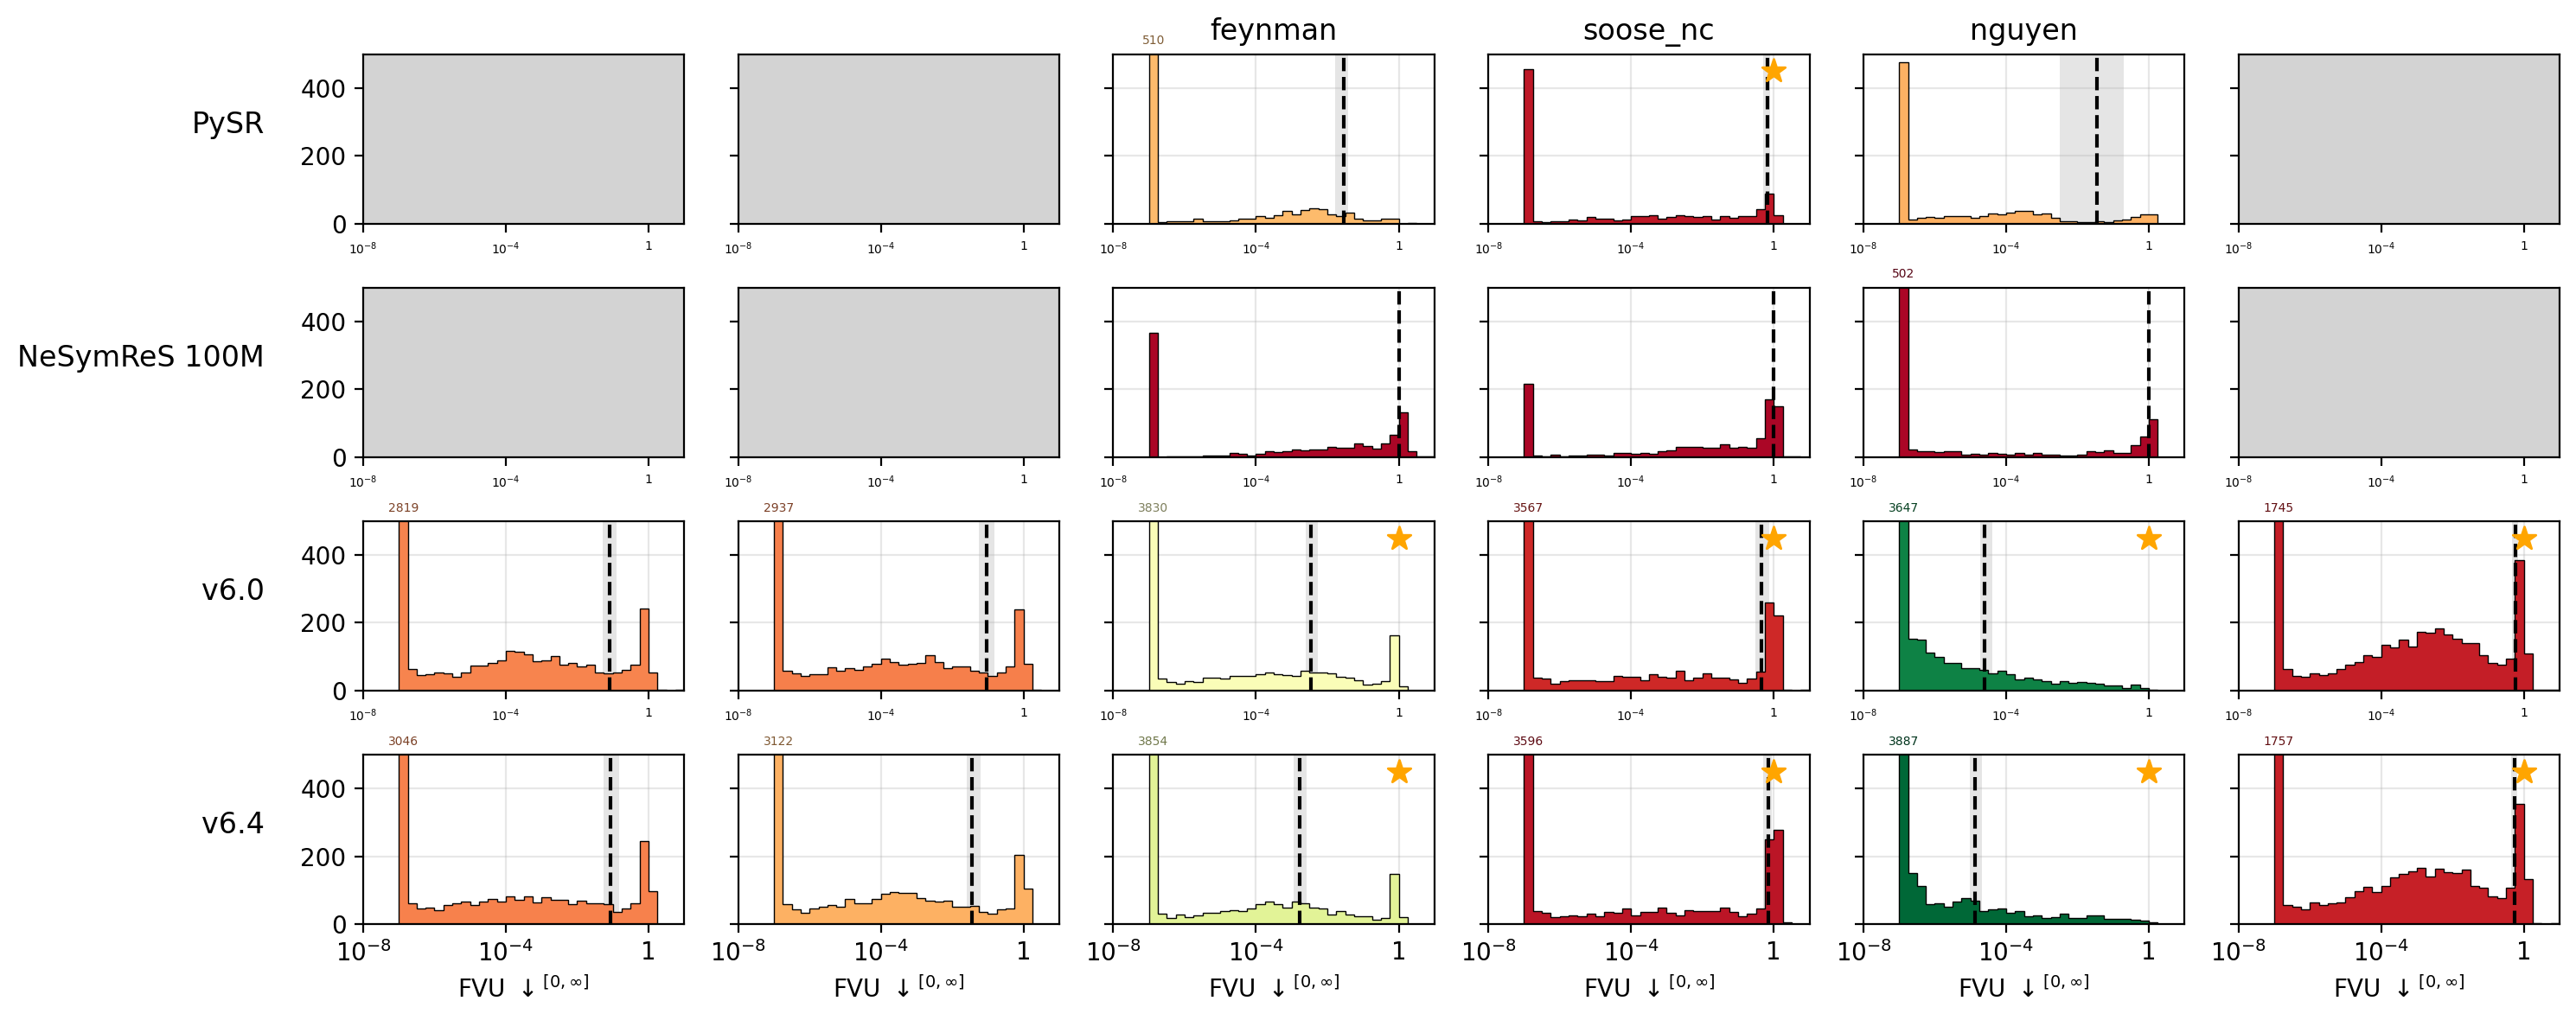

In [ ]:
ROWS = len(MODELS)
# COLS = max(len(model_test_sets) for model_test_sets in test_sets.values())
COLS = len(TEST_SETS)
N_BOOTSTRAPS = 1_000

fig, axes = plt.subplots(ROWS, COLS, figsize=(2.5 * COLS, 1.5 * ROWS), sharey=True, dpi=200)

axes = np.atleast_2d(axes)

xlim = (-8, 1)
bins = np.linspace(*xlim, (xlim[1] - xlim[0]) * 4 + 1)
# ylim = (0, 1.05 * max([max(np.histogram(array_dfs[model][test_set]['log_fvu'], bins=bins)[0]) for model in MODELS for test_set in test_sets[model]]))
ylim = (0, 500)

# Plot the distributions of a given metric for each model and test set
metric_name = 'log_fvu'

def stats_from_log_values(statistic):
    return lambda x: np.log(statistic(np.power(10, x)) + np.finfo(float).eps)

color_metric = lambda x: np.percentile(x[~np.isnan(x)], 90)

min_color_metric = np.min([np.min([color_metric(array_dfs[model][test_set][metric_name].replace(np.nan, 0).replace(np.inf, np.nan)) for test_set in test_sets[model] if test_set in array_dfs[model].keys()]) for model in MODELS])
max_color_metric = np.max([np.max([color_metric(array_dfs[model][test_set][metric_name].replace(np.nan, 0).replace(np.inf, np.nan)) for test_set in test_sets[model] if test_set in array_dfs[model].keys()]) for model in MODELS])

highest_lower_confidence_bound = {test_set: (None, np.inf) for test_set in TEST_SETS}

for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        ax = axes[i, j]
        ax.set_xticks([-8, -4, 0])
        ax.set_xticklabels([int_to_10(10**i) for i in [ -8, -4, 0]], fontdict={'fontsize': 5 if i != len(MODELS) - 1 else 10})
        if j == 0: ax.set_ylabel(MODELS_DESCRIPTION[model], rotation=0, labelpad=15, ha='right', fontsize=12)
        if i == len(MODELS) - 1: ax.set_xlabel(r'$\text{FVU}\,\,\downarrow^{[0, \infty]}$')
        if test_set not in array_dfs[model]:
            ax.set_xlim(xlim)
            ax.set_facecolor('lightgrey')
            continue
        data = array_dfs[model][test_set][metric_name].replace(np.nan, 0).replace(np.inf, np.nan).values

        color = plt.get_cmap('RdYlGn').reversed()((color_metric(data) - min_color_metric) / (max_color_metric - min_color_metric))

        ax.hist(data, bins=bins, color=color, zorder=2)
        ax.hist(data, bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)

        hist, bin_edges = np.histogram(data, bins=bins)
        for h, mid in zip(hist, (bin_edges[1:] + bin_edges[:-1]) / 2):
            if h > ylim[1]:
                ax.annotate(f'{h}', xy=(mid, ylim[1]), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=5, color=tuple(np.array(color)[:3] * 0.5) + (1,))

        median_median, median_5, median_95 = bootstrapped_metric_ci(data, color_metric, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            highest_lower_confidence_bound[test_set] = (model, median_95)

        ax.axvline(median_median, color='black', linestyle='--', zorder=3)
        # ax.errorbar(median_median, ylim[1], xerr=[[median_median - median_5], [median_95 - median_median]], fmt='.', color='black', zorder=4, capsize=3, markersize=0, clip_on=True)
        ax.axvspan(median_5, median_95, color='black', alpha=0.1, zorder=1, linewidth=0)
        ax.set_ylim(ylim)
        ax.grid(alpha=0.3, zorder=0)
        if i == 0: ax.set_title(test_set)
        ax.set_xlim(xlim)

within_lowest_upper_confidence_bound = {test_set: [] for test_set in TEST_SETS}
for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        if test_set not in array_dfs[model]:
            continue
        data = array_dfs[model][test_set][metric_name].replace(np.nan, 0).replace(np.inf, np.nan).values
        median_median, median_5, median_95 = bootstrapped_metric_ci(data, color_metric, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            within_lowest_upper_confidence_bound[test_set].append(model)

# For each test set, mark the model (row) with the lowest median log_fvu
for j, test_set in enumerate(TEST_SETS):
    if test_set in ['train', 'val']:
        continue
    models = within_lowest_upper_confidence_bound[test_set]
    for i, model in enumerate(MODELS):
        if model in models:
            axes[MODELS.index(model), j].scatter([0], [ylim[1] * 0.9], color='orange', marker='*', s=100, zorder=5)

fig.tight_layout(h_pad=0.5)

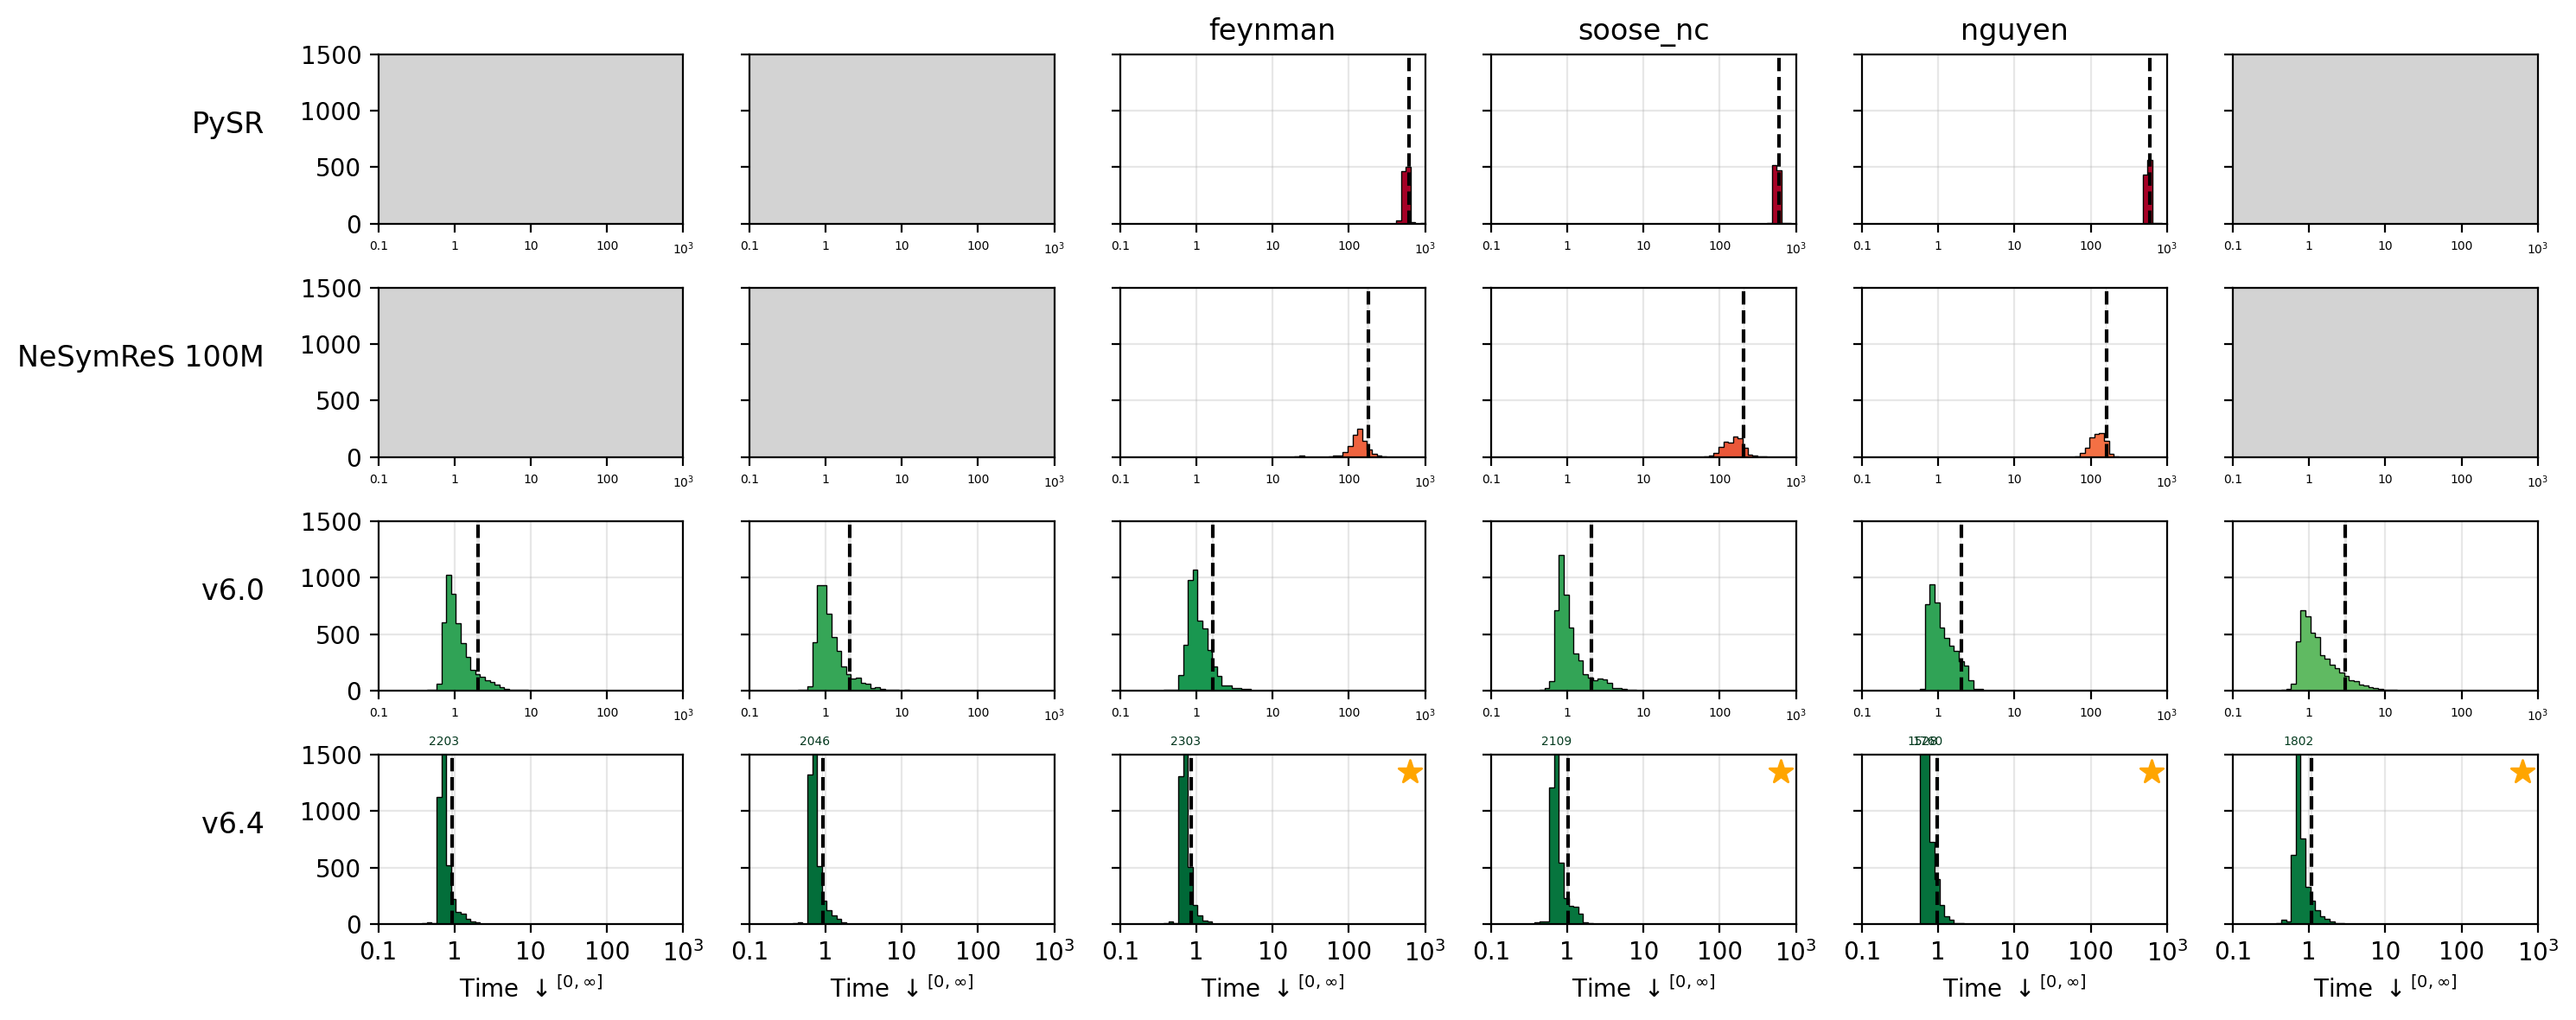

In [ ]:
ROWS = len(MODELS)
# COLS = max(len(model_test_sets) for model_test_sets in test_sets.values())
COLS = len(TEST_SETS)
N_BOOTSTRAPS = 1_000

fig, axes = plt.subplots(ROWS, COLS, figsize=(2.5 * COLS, 1.5 * ROWS), sharey=True, dpi=200)

axes = np.atleast_2d(axes)

xlim = (-1, 3)
bins = np.linspace(*xlim, 64)
# ylim = (0, 1.05 * max([max(np.histogram(array_dfs[model][test_set]['log_fvu'], bins=bins)[0]) for model in MODELS for test_set in test_sets[model]]))
ylim = (0, 1500)

# Plot the distributions of a given metric for each model and test set
metric_name = 'sys_time'

color_metric = lambda x: np.percentile(x[~np.isnan(x) & ~np.isinf(x)], 90)

min_color_metric = np.min([np.min([color_metric(np.log10(array_dfs[model][test_set][metric_name].replace(np.inf, np.nan))) for test_set in test_sets[model] if test_set in array_dfs[model].keys()]) for model in MODELS])
max_color_metric = np.max([np.max([color_metric(np.log10(array_dfs[model][test_set][metric_name].replace(np.inf, np.nan))) for test_set in test_sets[model] if test_set in array_dfs[model].keys()]) for model in MODELS])

highest_lower_confidence_bound = {test_set: (None, np.inf) for test_set in TEST_SETS}

for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        ax = axes[i, j]
        ax.set_xticks([-1, 0, 1, 2, 3])
        ax.set_xticklabels([int_to_10(10**i) for i in [-1, 0, 1, 2, 3]], fontdict={'fontsize': 5 if i != len(MODELS) - 1 else 10})
        if j == 0: ax.set_ylabel(MODELS_DESCRIPTION[model], rotation=0, labelpad=15, ha='right', fontsize=12)
        if i == len(MODELS) - 1: ax.set_xlabel(r'$\text{Time}\,\,\downarrow^{[0, \infty]}$')
        if test_set not in array_dfs[model]:
            ax.set_xlim(xlim)
            ax.set_facecolor('lightgrey')
            continue
        data = np.log10(array_dfs[model][test_set][metric_name].replace(np.inf, np.nan).values)

        color = plt.get_cmap('RdYlGn').reversed()((color_metric(data) - min_color_metric) / (max_color_metric - min_color_metric))

        ax.hist(data, bins=bins, color=color, zorder=2)
        ax.hist(data, bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)

        hist, bin_edges = np.histogram(data, bins=bins)
        for h, mid in zip(hist, (bin_edges[1:] + bin_edges[:-1]) / 2):
            if h > ylim[1]:
                ax.annotate(f'{h}', xy=(mid, ylim[1]), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=5, color=tuple(np.array(color)[:3] * 0.5) + (1,))

        median_median, median_5, median_95 = bootstrapped_metric_ci(data, color_metric, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            highest_lower_confidence_bound[test_set] = (model, median_95)

        ax.axvline(median_median, color='black', linestyle='--', zorder=3)
        # ax.errorbar(median_median, ylim[1], xerr=[[median_median - median_5], [median_95 - median_median]], fmt='.', color='black', zorder=4, capsize=3, markersize=0, clip_on=True)
        ax.axvspan(median_5, median_95, color='black', alpha=0.1, zorder=1, linewidth=0)
        ax.set_ylim(ylim)
        ax.grid(alpha=0.3, zorder=0)
        if i == 0: ax.set_title(test_set)
        ax.set_xlim(xlim)

within_lowest_upper_confidence_bound = {test_set: [] for test_set in TEST_SETS}
for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        if test_set not in array_dfs[model]:
            continue
        data = np.log10(array_dfs[model][test_set][metric_name].replace(np.inf, np.nan).values)
        median_median, median_5, median_95 = bootstrapped_metric_ci(data, color_metric, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            within_lowest_upper_confidence_bound[test_set].append(model)

# For each test set, mark the model (row) with the lowest median log_fvu
for j, test_set in enumerate(TEST_SETS):
    if test_set in ['train', 'val']:
        continue
    models = within_lowest_upper_confidence_bound[test_set]
    for i, model in enumerate(MODELS):
        if model in models:
            axes[MODELS.index(model), j].scatter([2.8], [ylim[1] * 0.9], color='orange', marker='*', s=100, zorder=5)

fig.tight_layout(h_pad=0.5)

In [ ]:
# from nsr import ExpressionSpace, get_path
# space = ExpressionSpace.from_config(get_path('configs/v4.2/expression_space.yaml'))
# from itertools import groupby
# from collections import Counter

In [ ]:
# lists = {model: {model_test_set: space.tokenizer.decode(results[model][model_test_set]['data']['labels']) for model_test_set in results[model].keys()} for model in MODELS for test_set in TEST_SETS}
# splits = {model: {model_test_set: [tuple(y) for x, y in groupby(lst, lambda z: z == '<eos>') if not x] for model_test_set, lst in v.items()} for model, v in lists.items()}

In [ ]:
# test_set_labels_union = {test_set: set.union(*[set([tuple(x) for x in splits[model].get(test_set, [])]) for model in MODELS]) for test_set in TEST_SETS}

# for k, v in test_set_labels_union.items():
#     print(k, len(v))

In [ ]:
# eq_data = {model: {test_set: {k: [array_dfs[model][test_set]['log_fvu'][i] for i in range(len(array_dfs[model][test_set]['log_fvu'])) if splits[model][test_set][i] == k] for k in test_set_labels_union[test_set]} for test_set in TEST_SETS if test_set in array_dfs[model].keys()} for model in MODELS}

In [ ]:
# # For each unique sequence, plot how often it appears in the test set
# fig, axes = plt.subplots(1, 2, figsize=(7, 3.2), dpi=200)

# compare_models = ['v4.2', 'v4.10']
# compare_test_set = 'soose_nc'

# max_count = max([max(Counter(splits[model][compare_test_set]).values()) for model in compare_models])

# counter_1 = Counter(splits[compare_models[0]][compare_test_set])
# counter_2 = Counter(splits[compare_models[1]][compare_test_set])

# axes[0].hist2d([counter_1.get(k, 0) for k in test_set_labels_union[compare_test_set]], [counter_2.get(k, 0) for k in test_set_labels_union[compare_test_set]], bins=range(0, max_count + 1), cmap='viridis')
# axes[0].set_xticks(0.5 + np.linspace(0, max_count + 1, 5)[:-1])
# axes[0].set_yticks(0.5 + np.linspace(0, max_count + 1, 5)[:-1])
# axes[0].set_xticklabels(np.linspace(0, max_count, 5, dtype=int)[:-1])
# axes[0].set_yticklabels(np.linspace(0, max_count, 5, dtype=int)[:-1])
# axes[0].set_xlabel(f'{compare_models[0]} count')
# axes[0].set_ylabel(f'{compare_models[1]} count')

# data = pd.DataFrame({
#     compare_models[0]: [np.nanmedian(eq_data[compare_models[0]][compare_test_set][k]) for k in test_set_labels_union[compare_test_set]],
#     compare_models[1]: [np.nanmedian(eq_data[compare_models[1]][compare_test_set][k]) for k in test_set_labels_union[compare_test_set]],
#     'count': [len(eq_data[compare_models[0]][compare_test_set][k]) for k in test_set_labels_union[compare_test_set]],
# })

# axes[1].scatter(data[compare_models[0]], data[compare_models[1]], alpha=0.5, s=data['count'] * 2)
# axes[1].set_xlim(-17, 1)
# axes[1].set_ylim(-17, 1)
# axes[1].set_xticks([-16, -12, -8, -4, 0])
# axes[1].set_yticks([-16, -12, -8, -4, 0])
# axes[1].set_xlabel(f'{compare_models[0]} log FVU')
# axes[1].set_ylabel(f'{compare_models[1]} log FVU')

# fig.tight_layout(w_pad=3)

In [ ]:
# sorted(results['v4.2']['soose_nc']['data']['log_fvu'])[:10]

In [ ]:
# sorted(results['v4.10']['soose_nc']['data']['log_fvu'])[:10]

In [ ]:
# # Show the 10 easiest equations of 'v4.2' measured by log FVU
# easy2 = sorted([(k, np.nanmean(v), len(v)) for k, v in eq_data['v4.2']['soose_nc'].items()], key=lambda x: x[1] if not np.isnan(x[1]) else np.inf)[:20]

# for k, v, l in easy2:
#     print(f'{space.prefix_to_infix(k):<50} {v:>6.2f} ({l}) {np.nanmean(eq_data["v4.10"]["soose_nc"].get(k, [])):>6.2f} ({len(eq_data["v4.10"]["soose_nc"].get(k, []))})')

In [ ]:
UNIQUE_MODELS_NO_NESYMRES = [m for m in UNIQUE_MODELS if m != 'nesymres-100M']

NameError: name 'UNIQUE_MODELS' is not defined

/tmp/ipykernel_27333/3817520256.py:15: RuntimeWarning: Mean of empty slice
  min_color_metric = np.nanmin([np.nanmin([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in UNIQUE_MODELS_NO_NESYMRES])
/tmp/ipykernel_27333/3817520256.py:15: RuntimeWarning: All-NaN axis encountered
  min_color_metric = np.nanmin([np.nanmin([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in UNIQUE_MODELS_NO_NESYMRES])
/tmp/ipykernel_27333/3817520256.py:16: RuntimeWarning: Mean of empty slice
  max_color_metric = np.nanmax([np.nanmax([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in UNIQUE_MODELS_NO_NESYMRES])
/tmp/ipykernel_27333/3817520256.py:16: RuntimeWarning: All-NaN axis encountered
  max_color_metric = np.nanmax([np.nanmax([color_metric(array_dfs[model][test_set].get(metric_na

ValueError: Cannot index with multidimensional key

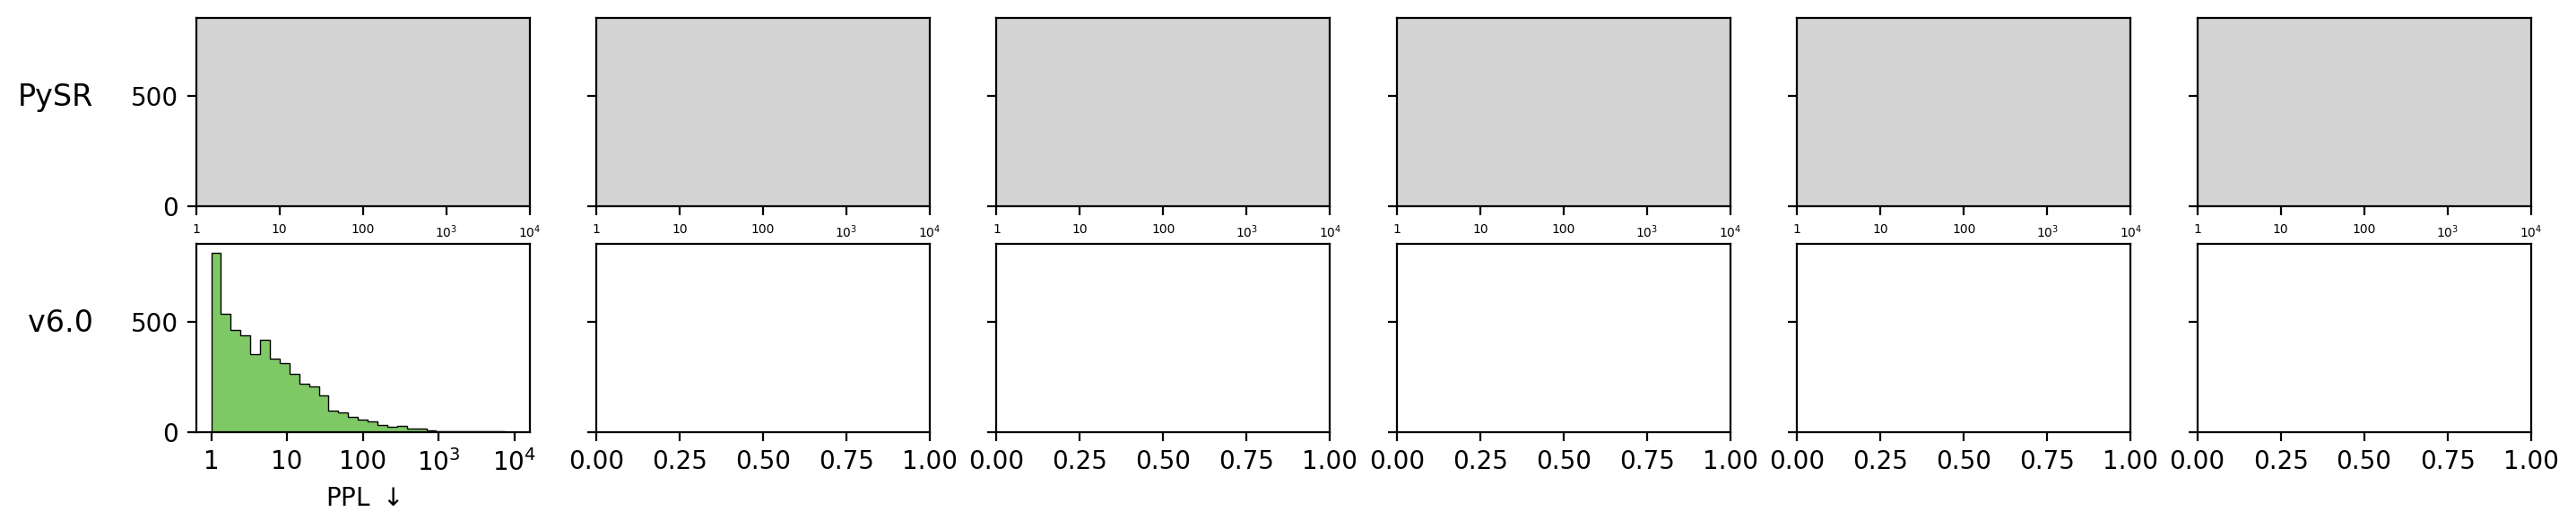

In [ ]:
ROWS = len(UNIQUE_MODELS_NO_NESYMRES)
# COLS = max(len(model_test_sets) for model_test_sets in test_sets.values())
COLS = len(TEST_SETS)
fig, axes = plt.subplots(ROWS, COLS, figsize=(2.8 * COLS, 1.5 * ROWS), sharey=True, dpi=200)

metric_name = 'log_ppl'

xlim = (0, 4)
bins = np.linspace(*xlim, 32)
ylim = (0, 1.05 * max([max(np.histogram(array_dfs[model][test_set].get(metric_name, np.array([np.nan])), bins=bins)[0]) for model in UNIQUE_MODELS_NO_NESYMRES for test_set in test_sets[model]]))

# Plot the distributions of a given metric for each model and test set
color_metric = np.nanmean

min_color_metric = np.nanmin([np.nanmin([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in UNIQUE_MODELS_NO_NESYMRES])
max_color_metric = np.nanmax([np.nanmax([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in UNIQUE_MODELS_NO_NESYMRES])

highest_lower_confidence_bound = {test_set: (None, np.inf) for test_set in TEST_SETS}

for i, model in enumerate(UNIQUE_MODELS_NO_NESYMRES):
    for j, test_set in enumerate(TEST_SETS):
        ax = axes[i, j]
        ax.set_xticks(range(xlim[0], xlim[1] + 1))
        ax.set_xticklabels([int_to_10(10**i) for i in range(xlim[0], xlim[1] + 1)], fontdict={'fontsize': 5 if i != len(UNIQUE_MODELS_NO_NESYMRES) - 1 else 10})
        if j == 0: ax.set_ylabel(MODELS_DESCRIPTION[model], rotation=0, labelpad=15, ha='right', fontsize=12)
        if i == len(UNIQUE_MODELS_NO_NESYMRES) - 1: ax.set_xlabel(r'$\text{PPL}\,\,\downarrow$')
        if test_set not in array_dfs[model] or metric_name not in array_dfs[model][test_set] or array_dfs[model][test_set][metric_name].isnull().all():
            ax.set_xlim(xlim)
            ax.set_facecolor('lightgrey')
            continue
        data = array_dfs[model][test_set].get(metric_name, pd.Series([np.nan])).replace(np.nan, np.inf)
        ax.hist(data, bins=bins, color=plt.get_cmap('RdYlGn').reversed()((color_metric(data) - min_color_metric) / (max_color_metric - min_color_metric)), zorder=2)
        ax.hist(data, bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)

        median_median, median_5, median_95 = bootstrapped_metric_ci(data, np.nanmean)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            highest_lower_confidence_bound[test_set] = (model, median_95)

        ax.axvline(median_median, color='black', linestyle='--', zorder=3)
        # ax.errorbar(median_median, ylim[1], xerr=[[median_median - median_5], [median_95 - median_median]], fmt='.', color='black', zorder=4, capsize=3, markersize=0, clip_on=True)
        ax.axvspan(median_5, median_95, color='black', alpha=0.1, zorder=1, linewidth=0)
        ax.set_ylim(ylim)
        ax.grid(alpha=0.3, zorder=0)
        if i == 0: ax.set_title(test_set)
        ax.set_xlim(xlim)


within_lowest_upper_confidence_bound = {test_set: [] for test_set in TEST_SETS}
for i, model in enumerate(UNIQUE_MODELS_NO_NESYMRES):
    for j, test_set in enumerate(TEST_SETS):
        if test_set not in array_dfs[model]:
            continue
        data = array_dfs[model][test_set].get(metric_name, pd.Series([np.nan])).replace(np.nan, np.inf)
        median_median, median_5, median_95 = bootstrapped_metric_ci(data, np.nanmean)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            within_lowest_upper_confidence_bound[test_set].append(model)

# For each test set, mark the model (row) with the lowest median log_fvu
for j, test_set in enumerate(TEST_SETS):
    if test_set in ['train', 'val']:
        continue
    models = within_lowest_upper_confidence_bound[test_set]
    for i, model in enumerate(UNIQUE_MODELS_NO_NESYMRES):
        if model in models:
            axes[UNIQUE_MODELS_NO_NESYMRES.index(model), j].scatter([xlim[1] * 0.95], [ylim[1] * 0.9], color='orange', marker='*', s=100, zorder=5)

fig.tight_layout(h_pad=0)

In [ ]:
MODELS_WITH_BEAMS = [model for model in MODELS if any('beam_2' in k for k in results[model]['feynman']['data'].keys())]

KeyError: 'feynman'

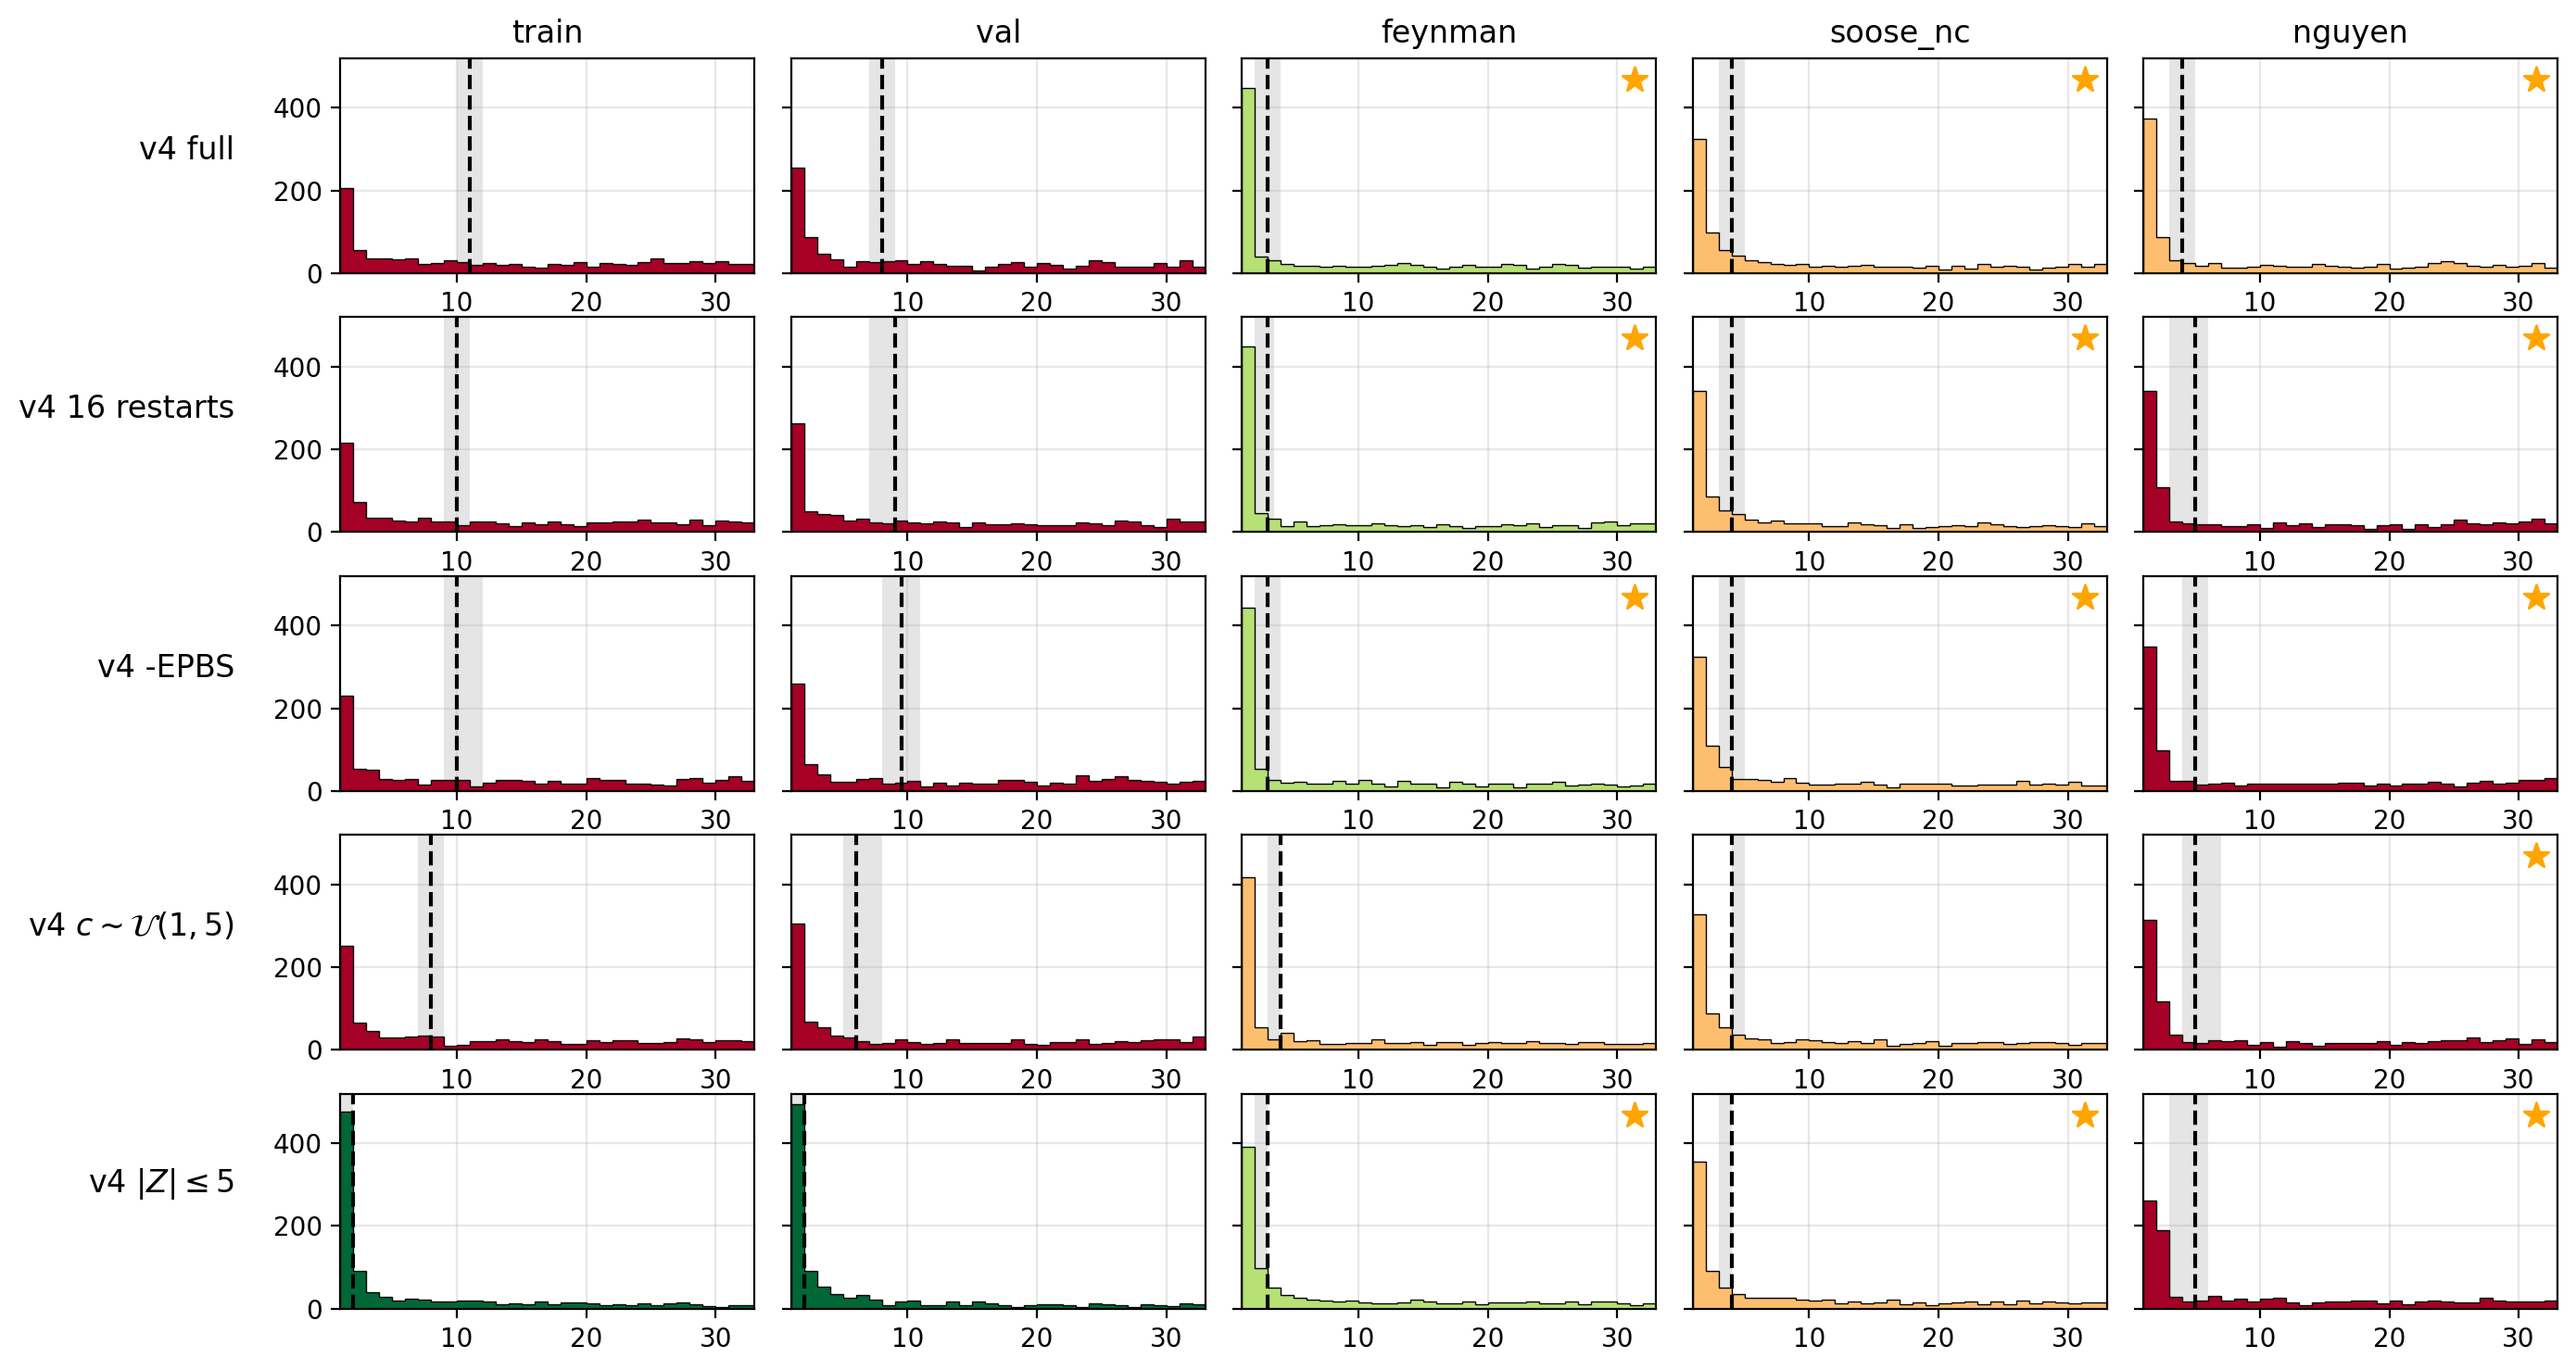

In [ ]:
ROWS = len(MODELS_WITH_BEAMS)
COLS = max(len(model_test_sets) for model_test_sets in test_sets.values())
fig, axes = plt.subplots(ROWS, COLS, figsize=(2.8 * COLS, 1.5 * ROWS), sharey=True, dpi=200)
N_BOOTSTRAPS = 1000
metric_name = 'best_beam'

xlim = (1, 33)
bins = np.linspace(*xlim, 33)
ylim = (0, 1.05 * max([max(np.histogram(array_dfs[model][test_set].get(metric_name, np.array([np.nan])), bins=bins)[0]) for model in MODELS_WITH_BEAMS for test_set in test_sets[model]]))

# Plot the distributions of a given metric for each model and test set
color_metric = np.median

min_color_metric = np.nanmin([np.nanmin([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in MODELS_WITH_BEAMS])
max_color_metric = np.nanmax([np.nanmax([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in MODELS_WITH_BEAMS])

highest_lower_confidence_bound = {test_set: (None, np.inf) for test_set in TEST_SETS}

for i, model in enumerate(MODELS_WITH_BEAMS):
    for j, test_set in enumerate(TEST_SETS):
        ax = axes[i, j]
        # ax.set_xticks(range(xlim[0], xlim[1] + 1))
        # ax.set_xticklabels([int_to_10(10**i) for i in range(xlim[0], xlim[1] + 1)], fontdict={'fontsize': 5 if i != len(MODELS) - 1 else 12})
        if j == 0: ax.set_ylabel(MODELS_DESCRIPTION[model], rotation=0, labelpad=15, ha='right', fontsize=12)
        if i == len(MODELS) - 1: ax.set_xlabel(r'$\text{PPL}\,\,\downarrow$')
        if test_set not in array_dfs[model] or metric_name not in array_dfs[model][test_set] or array_dfs[model][test_set][metric_name].isnull().all():
            ax.set_xlim(xlim)
            ax.set_facecolor('lightgrey')
            continue
        data = array_dfs[model][test_set].get(metric_name, pd.Series([np.nan])).replace(np.nan, np.inf)
        ax.hist(data, bins=bins, color=plt.get_cmap('RdYlGn').reversed()((color_metric(data) - min_color_metric) / (max_color_metric - min_color_metric)), zorder=2)
        ax.hist(data, bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)

        median_median, median_5, median_95 = bootstrapped_metric_ci(data, np.median, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            highest_lower_confidence_bound[test_set] = (model, median_95)

        ax.axvline(median_median, color='black', linestyle='--', zorder=3)
        # ax.errorbar(median_median, ylim[1], xerr=[[median_median - median_5], [median_95 - median_median]], fmt='.', color='black', zorder=4, capsize=3, markersize=0, clip_on=True)
        ax.axvspan(median_5, median_95, color='black', alpha=0.1, zorder=1, linewidth=0)
        ax.set_ylim(ylim)
        ax.grid(alpha=0.3, zorder=0)
        if i == 0: ax.set_title(test_set)
        ax.set_xlim(xlim)

within_lowest_upper_confidence_bound = {test_set: [] for test_set in TEST_SETS}
for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        if test_set not in array_dfs[model]:
            continue
        data = array_dfs[model][test_set].get(metric_name, pd.Series([np.nan])).replace(np.nan, np.inf)
        median_median, median_5, median_95 = bootstrapped_metric_ci(data, np.median, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            within_lowest_upper_confidence_bound[test_set].append(model)

# For each test set, mark the model (row) with the lowest median log_fvu
for j, test_set in enumerate(TEST_SETS):
    if test_set in ['train', 'val']:
        continue
    models = within_lowest_upper_confidence_bound[test_set]
    for i, model in enumerate(MODELS_WITH_BEAMS):
        if model in models:
            axes[MODELS.index(model), j].scatter([xlim[1] * 0.95], [ylim[1] * 0.9], color='orange', marker='*', s=100, zorder=5)

fig.tight_layout(h_pad=0)

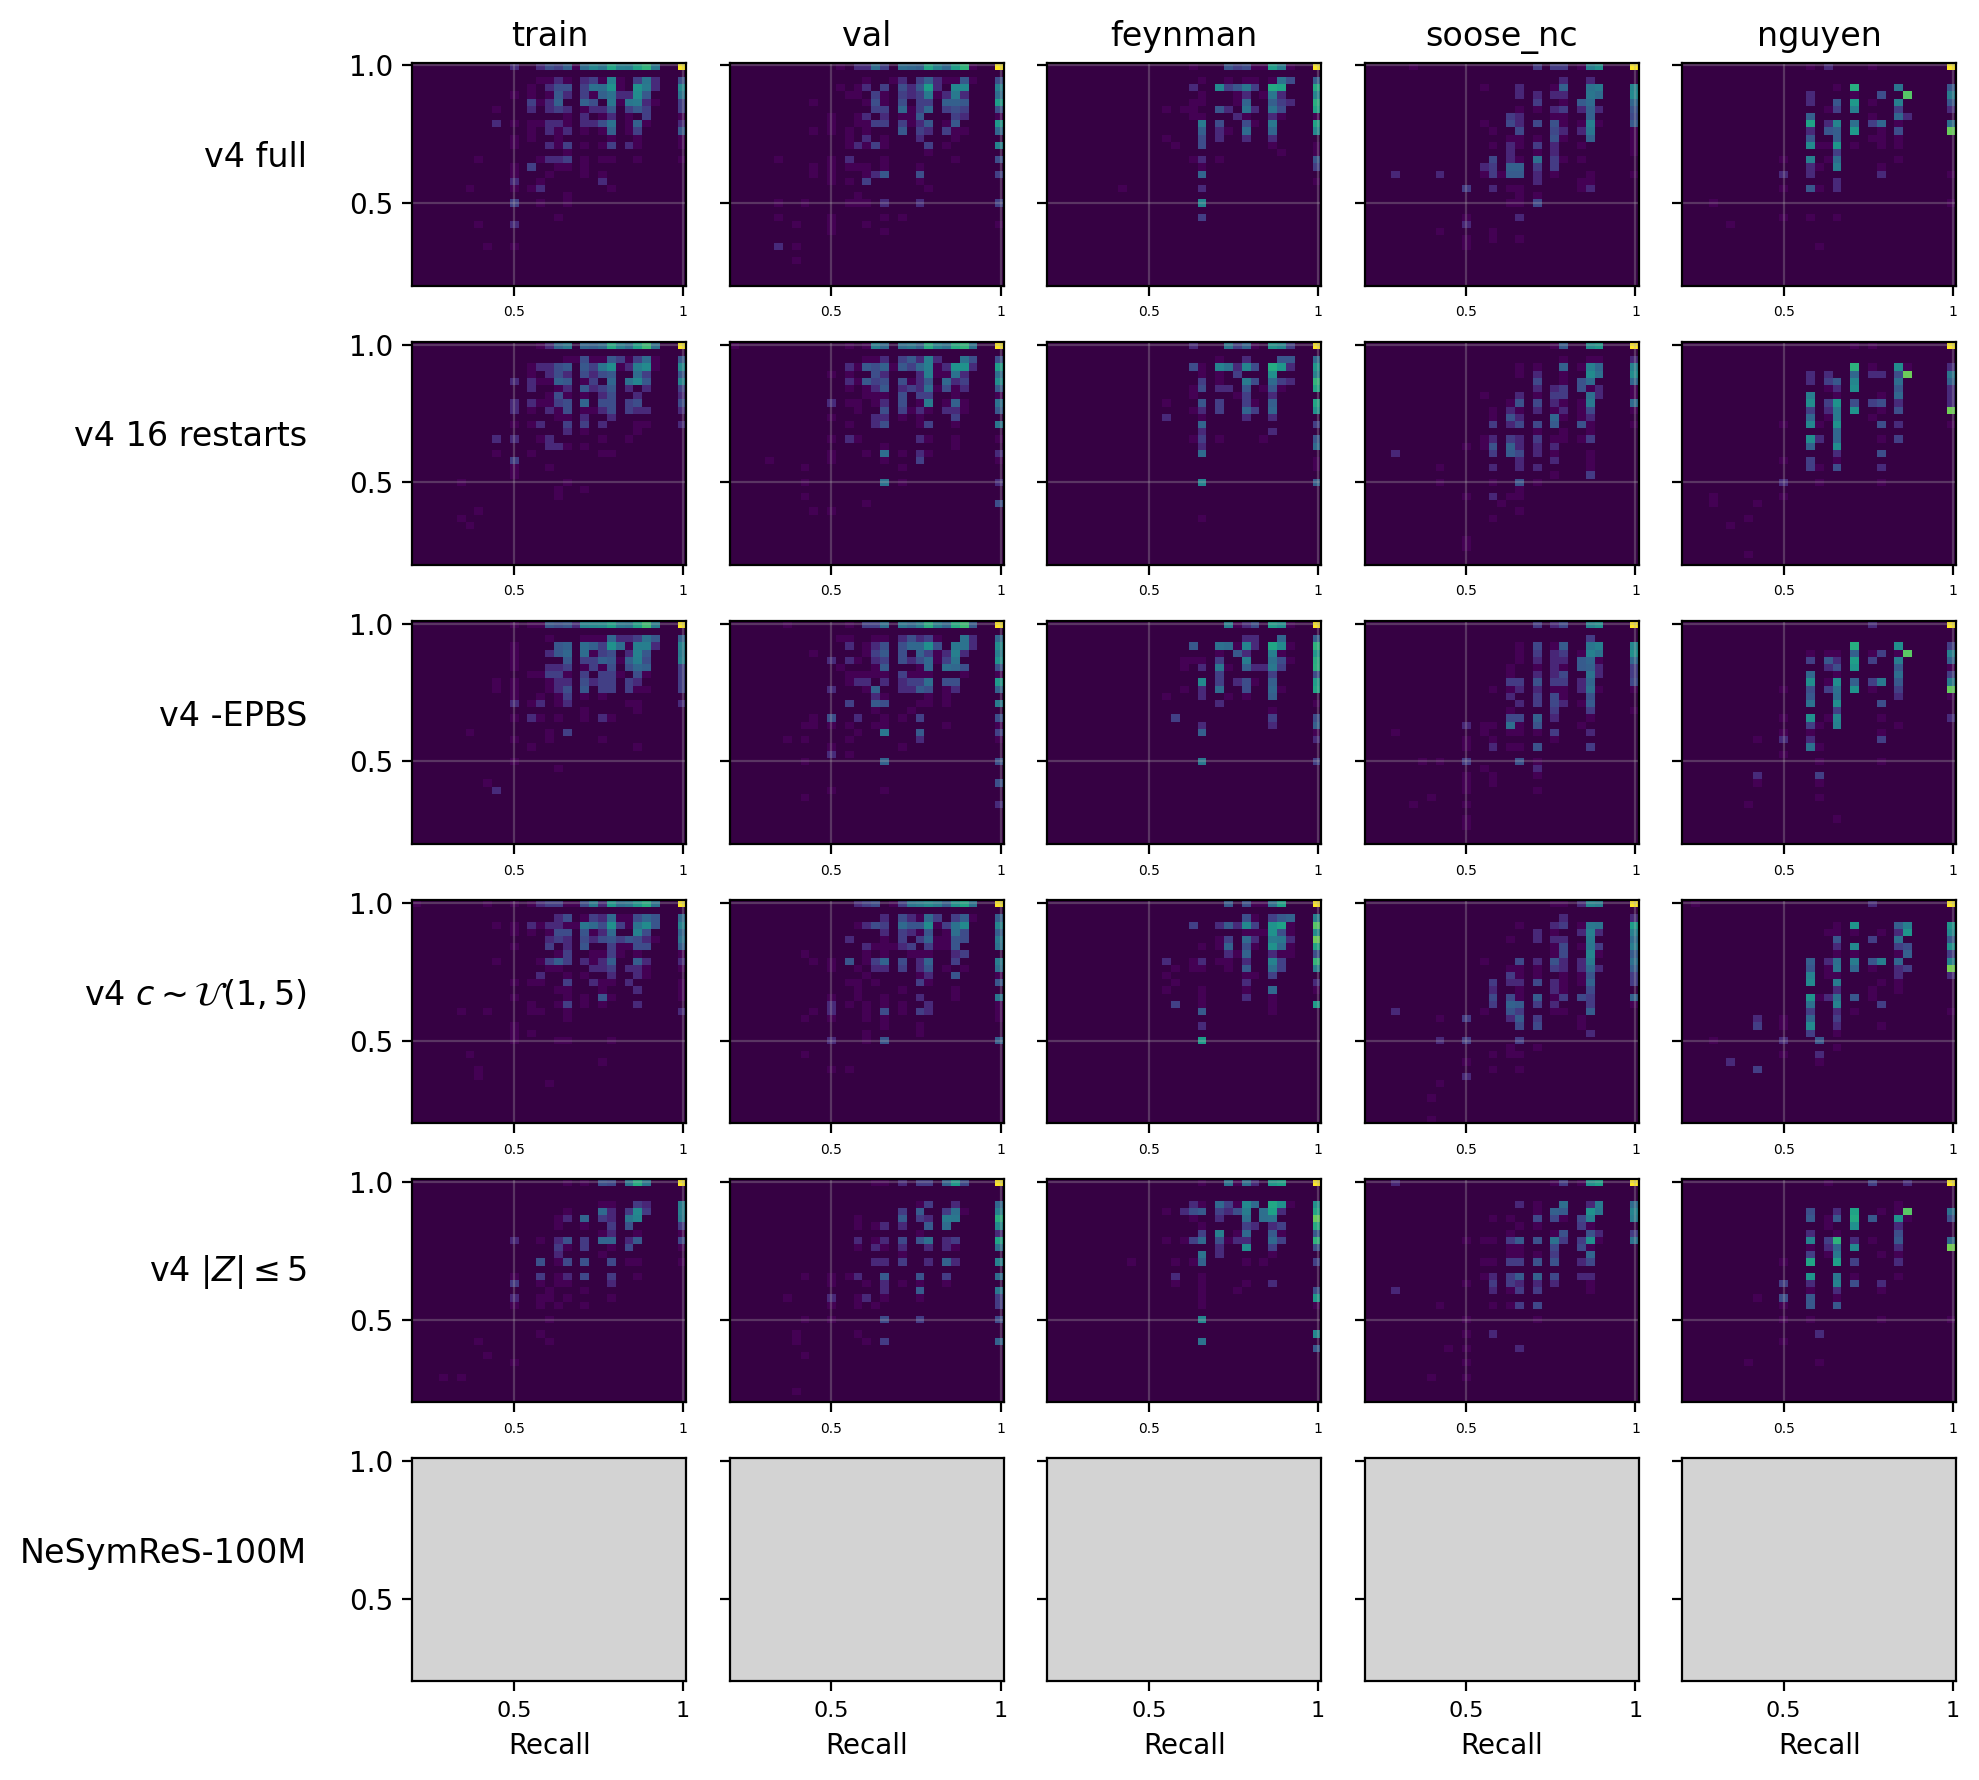

In [ ]:
# For each model and test set, scatter plot the recall-precision curve
ROWS = len(MODELS)
COLS = max(len(model_test_sets) for model_test_sets in test_sets.values())
fig, axes = plt.subplots(ROWS, COLS, figsize=(2 * COLS, 1.5 * ROWS), sharey=True, dpi=200)

metric_name_x = 'recall_best_beam'
metric_name_y = 'precision_best_beam'

xlim = (0.2, 1.01)
ylim = xlim

bins = np.linspace(*xlim, 32)

for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        ax = axes[i, j]
        ax.set_xticks([0.5, 1])
        ax.set_yticks([0.5, 1])
        ax.set_xticklabels([0.5, 1], fontdict={'fontsize': 5 if i != len(MODELS) - 1 else 8})
        if j == 0: ax.set_ylabel(MODELS_DESCRIPTION[model], rotation=0, labelpad=15, ha='right', fontsize=12)
        if i == len(MODELS) - 1: ax.set_xlabel('Recall')
        if test_set not in array_dfs[model] or metric_name_x not in array_dfs[model][test_set] or metric_name_y not in array_dfs[model][test_set]:
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_facecolor('lightgrey')
            continue
        data_x = array_dfs[model][test_set].get(metric_name_x, pd.Series([np.nan])).replace(np.nan, 0)
        data_y = array_dfs[model][test_set].get(metric_name_y, pd.Series([np.nan])).replace(np.nan, 0)
        ax.hist2d(data_x, data_y, bins=bins, cmap='viridis', norm=plt.cm.colors.LogNorm())
        ax.set_facecolor(tuple(np.array(plt.get_cmap('viridis')(0)[:3]) * 0.8) + (1, ))
        # ax.scatter(data_x, data_y, s=1, zorder=2, alpha=0.5)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.grid(alpha=0.3, zorder=0)
        if i == 0: ax.set_title(test_set)

fig.tight_layout(h_pad=0.5)